<a href="https://colab.research.google.com/github/punnarat-w/Yomriver_analysis/blob/main/ForecastingModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
!pip install pmdarima

In [100]:
!pip install fbprophet

In [179]:
# importing library
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from fbprophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

#Retrieving Data

In [102]:
# download description file
!gdown --id 1GJdM5L1SH1Cs95xFeflf3HT7kLT4wd-f

Downloading...
From: https://drive.google.com/uc?id=1GJdM5L1SH1Cs95xFeflf3HT7kLT4wd-f
To: /content/st.csv
100% 20.8k/20.8k [00:00<00:00, 41.3MB/s]


In [103]:
def getData(filename):
  data = pd.read_csv(filename)
  # data['Datetime'] = pd.to_datetime(data['Datetime'])
  # data = data.set_index('Datetime')
  return data

In [104]:
description = getData('st.csv')
description

,code,name,lat,long,tambon,amphoe,province,basin,region,station_type
0,BDLH,ทต.ลานหอย,17.008562,99.582995,ลานหอย,บ้านด่านลานหอย,สุโขทัย,ภาคเหนือ,R,NaN
1,SAMN,ทต.สามง่าม,16.512774,100.208275,สามง่าม,สามง่าม,พิจิตร,ภาคเหนือ,R,NaN
2,SNGT,อบต.บ้านกลาง,18.482018,100.177530,บ้านกลาง,สอง,แพร่,ภาคเหนือ,R,NaN
3,KPPT,อบจ.กำแพงเพชร,16.410858,99.521990,อ่างทอง,เมืองกำแพงเพชร,กำแพงเพชร,ภาคเหนือ,R,NaN
4,PKTI,ทต.พรานกระต่าย,16.653760,99.575782,พรานกระต่าย,พรานกระต่าย,กำแพงเพชร,ภาคเหนือ,R,NaN
...,...,...,...,...,...,...,...,...,...,...
109,VLGE13,ชุมแสงสงคราม,16.858560,100.059642,ชุมแสงสงคราม,บางระกำ,พิษณุโลก,ภาคเหนือ,W,NaN
110,VLGE15,ชุมชนหนองปิ้งไก่,16.434798,99.367315,นาบ่อคำ,เมืองกำแพงเพชร,กำแพงเพชร,ภาคเหนือ,R,NaN
111,VLGE12,นครป่าหมาก,16.623374,100.369210,นครป่าหมาก,บางกระทุ่ม,พิษณุโลก,ภาคเหนือ,W,NaN
112,TBW014,สะพานข้ามคลองเกรียงไกร,15.843182,100.211475,บางเคียน,ชุมแสง,นครสวรรค์,ภาคเหนือ,W,NaN


In [105]:
description['region'].value_counts()

R    77
W    37
Name: region, dtype: int64

Finding the code of chosen stations

In [106]:
description[description['name'] == 'ทต.เชียงม่วน']

,code,name,lat,long,tambon,amphoe,province,basin,region,station_type
32,CGMN,ทต.เชียงม่วน,18.893837,100.28784,เชียงม่วน,เชียงม่วน,พะเยา,ภาคเหนือ,R,NaN


In [107]:
description[description['name'] == 'อบต.วังชิ้น']

,code,name,lat,long,tambon,amphoe,province,basin,region,station_type
25,WCHN,อบต.วังชิ้น,17.87883,99.61927,วังชิ้น,วังชิ้น,แพร่,ภาคเหนือ,R,NaN


In [108]:
description[description['name'] == 'โรงฆ่าสัตว์ ทม.สวรรคโลก']

,code,name,lat,long,tambon,amphoe,province,basin,region,station_type
17,SWKL,โรงฆ่าสัตว์ ทม.สวรรคโลก,17.31681,99.825146,เมืองสวรรคโลก,สวรรคโลก,สุโขทัย,ภาคเหนือ,R,NaN


##Download data

In [109]:
# download station file
!gdown --id 1ebJddYtRmEJbU9ITdvObE0IGr2zz5K0f
!gdown --id 1dj14nux3FyViM9heQwHxio1QZleZoZJx
!gdown --id 1hT_L86beygC_OQ1jMushxeDga8ZBM9Js

Downloading...
From: https://drive.google.com/uc?id=1ebJddYtRmEJbU9ITdvObE0IGr2zz5K0f
To: /content/CGMN.csv
3.72MB [00:00, 55.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dj14nux3FyViM9heQwHxio1QZleZoZJx
To: /content/WCHN.csv
3.65MB [00:00, 115MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hT_L86beygC_OQ1jMushxeDga8ZBM9Js
To: /content/SWKL.csv
3.69MB [00:00, 117MB/s]


In [110]:
north_df = getData('CGMN.csv')
mid_df = getData('WCHN.csv')
south_df = getData('SWKL.csv')

In [111]:
# download storm file
!gdown --id 1Sj-7RPCg6Ul4CWFdZ-hLAiWpVCzf-2_L

Downloading...
From: https://drive.google.com/uc?id=1Sj-7RPCg6Ul4CWFdZ-hLAiWpVCzf-2_L
To: /content/Storm_2010-2020.csv
100% 17.8k/17.8k [00:00<00:00, 16.4MB/s]


In [112]:
storm_df = getData('Storm_2010-2020.csv')
# storm_df

In [113]:
# download forest file
!gdown --id 1pv_GeEmjiED-x_3KFTkIzKaYAIhTr_QG

Downloading...
From: https://drive.google.com/uc?id=1pv_GeEmjiED-x_3KFTkIzKaYAIhTr_QG
To: /content/ForestNorth_2013-2019.csv
100% 1.55k/1.55k [00:00<00:00, 1.28MB/s]


In [114]:
forest_df = getData('ForestNorth_2013-2019.csv')
forest_df

,Year,Province,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area
0,2019,ตอนบน,"19,254,452.30","12,103,104.21",60.92,117.24
1,2019,ตอนกลาง,"4,051,912.64","2,627,401.47",64.84,35.16
2,2019,ตอนล่าง,"84,183,434.55","41,661,864.73",43.46,734.97
3,2018,ตอนบน,"19,254,452.30","12,128,810.16",61.05,116.86
4,2018,ตอนกลาง,"4,051,912.64","2,623,909.73",64.76,35.24
5,2018,ตอนล่าง,"84,183,434.55","41,728,212.55",43.51,734.36
6,2017,ตอนบน,"19,254,452.30","12,115,729.16",60.97,117.08
7,2017,ตอนกลาง,"4,051,912.64","2,610,863.30",64.44,35.56
8,2017,ตอนล่าง,"84,183,434.55","41,652,816.09",43.38,736.00
9,2016,ตอนบน,"19,254,452.30","12,177,949.25",61.30,116.11


#Data Preparation

##Combining data

###Merging data sets

In [115]:
def insertkey(df):
  # insert column key in df for merge data
  n_10 = df[df.date.str.contains('2010')]
  n_10.insert(0, "Key", "10")
  n_11 = df[df.date.str.contains('2011')]
  n_11.insert(0, "Key", "11")
  n_12 = df[df.date.str.contains('2012')]
  n_12.insert(0, "Key", "12")
  n_13 = df[df.date.str.contains('2013')]
  n_13.insert(0, "Key", "13")
  n_14 = df[df.date.str.contains('2014')]
  n_14.insert(0, "Key", "14")
  n_15 = df[df.date.str.contains('2015')]
  n_15.insert(0, "Key", "15")
  n_16 = df[df.date.str.contains('2016')]
  n_16.insert(0, "Key", "16")
  n_17 = df[df.date.str.contains('2017')]
  n_17.insert(0, "Key", "17")
  n_18 = df[df.date.str.contains('2018')]
  n_18.insert(0, "Key", "18")
  n_19 = df[df.date.str.contains('2019')]
  n_19.insert(0, "Key", "19")
  n_20 = df[df.date.str.contains('2020')]
  n_20.insert(0, "Key", "20")
  df = pd.concat([n_10, n_11, n_12, n_13, n_14, n_15, n_16, n_17, n_18, n_19, n_20], sort=False)
  return df

In [116]:
# insert column key in north_df for merge data
north_df = insertkey(north_df)
mid_df = insertkey(mid_df)
south_df = insertkey(south_df)
north_df.head()

,Key,code,date,time,rain1h,temp_out,press,humid
0,10,CGMN,2010-01-01,00:00,-999.0,-999.0,-999.0,-999.0
1,10,CGMN,2010-01-01,01:00,-999.0,-999.0,-999.0,-999.0
2,10,CGMN,2010-01-01,02:00,-999.0,-999.0,-999.0,-999.0
3,10,CGMN,2010-01-01,03:00,-999.0,-999.0,-999.0,-999.0
4,10,CGMN,2010-01-01,04:00,-999.0,-999.0,-999.0,-999.0


In [117]:
def insertkey_forest(df):
  # insert column key in nf_df for merge data
  nf_10 = df[df['Year'] == '2010']
  nf_10.insert(0, "Key", "10")
  nf_11 = df[df['Year'] == '2011']
  nf_11.insert(0, "Key", "11")
  nf_12 = df[df['Year'] == '2012']
  nf_12.insert(0, "Key", "12")
  nf_13 = df[df['Year'] == '2013']
  nf_13.insert(0, "Key", "13")
  nf_14 = df[df['Year'] == '2014']
  nf_14.insert(0, "Key", "14")
  nf_15 = df[df['Year'] == '2015']
  nf_15.insert(0, "Key", "15")
  nf_16 = df[df['Year'] == '2016']
  nf_16.insert(0, "Key", "16")
  nf_17 = df[df['Year'] == '2017']
  nf_17.insert(0, "Key", "17")
  nf_18 = df[df['Year'] == '2018']
  nf_18.insert(0, "Key", "18")
  nf_19 = df[df['Year'] == '2019']
  nf_19.insert(0, "Key", "19")
  nf_20 = df[df['Year'] == '2020']
  nf_20.insert(0, "Key", "20")
  df = pd.concat([nf_10, nf_11, nf_12, nf_13, nf_14, nf_15, nf_16, nf_17, nf_18, nf_19, nf_20], sort=False)
  return df

In [118]:
def prepare_forestdata(forest_df):
  nf_df = forest_df[forest_df['Province'] == 'ตอนบน']
  mf_df = forest_df[forest_df['Province'] == 'ตอนกลาง']
  sf_df = forest_df[forest_df['Province'] == 'ตอนล่าง']
  nf_df = nf_df.astype(str)
  mf_df = mf_df.astype(str)
  sf_df = sf_df.astype(str)
  nf_df = insertkey_forest(nf_df)
  mf_df = insertkey_forest(mf_df)
  sf_df = insertkey_forest(sf_df)
  return nf_df, mf_df, sf_df


In [119]:
def combine_with_forest(north_df, nf_df, mid_df, mf_df, south_df, sf_df):
  data_north = pd.merge(north_df, nf_df, on="Key", how="outer")
  data_mid = pd.merge(mid_df, mf_df, on="Key", how="outer")
  data_south = pd.merge(south_df, sf_df, on="Key", how="outer")
  return data_north, data_mid, data_south

In [120]:
nf_df, mf_df, sf_df = prepare_forestdata(forest_df)

In [121]:
north_df, mid_df, south_df = combine_with_forest(north_df, nf_df, mid_df, mf_df, south_df, sf_df)

In [122]:
#mid_df



##Data Cleansing



In [123]:
#overview data
print("สถานีทต.เชียงม่วน")
display(north_df)
print("\n\nสถานีอบต.วังชิ้น")
display(mid_df)
print("\n\nสถานีโรงฆ่าสัตว์ ทม.สวรรคโลก")
display(south_df)

สถานีทต.เชียงม่วน


,Key,code,date,time,rain1h,temp_out,press,humid,Year,Province,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area
0,10,CGMN,2010-01-01,00:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN,NaN,NaN
1,10,CGMN,2010-01-01,01:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN,NaN,NaN
2,10,CGMN,2010-01-01,02:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN,NaN,NaN
3,10,CGMN,2010-01-01,03:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN,NaN,NaN
4,10,CGMN,2010-01-01,04:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96427,20,CGMN,2020-12-31,19:00,0.0,24.8,981.8,61.4,NaN,NaN,NaN,NaN,NaN,NaN
96428,20,CGMN,2020-12-31,20:00,0.0,23.8,982.7,64.0,NaN,NaN,NaN,NaN,NaN,NaN
96429,20,CGMN,2020-12-31,21:00,0.0,23.2,983.6,63.5,NaN,NaN,NaN,NaN,NaN,NaN
96430,20,CGMN,2020-12-31,22:00,0.0,22.7,983.9,64.9,NaN,NaN,NaN,NaN,NaN,NaN




สถานีอบต.วังชิ้น


,Key,code,date,time,rain1h,temp_out,press,humid,Year,Province,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area
0,10,WCHN,2010-01-01,00:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN,NaN,NaN
1,10,WCHN,2010-01-01,01:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN,NaN,NaN
2,10,WCHN,2010-01-01,02:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN,NaN,NaN
3,10,WCHN,2010-01-01,03:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN,NaN,NaN
4,10,WCHN,2010-01-01,04:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96427,20,WCHN,2020-12-31,19:00,0.0,22.8,998.5,81.9,NaN,NaN,NaN,NaN,NaN,NaN
96428,20,WCHN,2020-12-31,20:00,0.0,21.3,999.6,86.4,NaN,NaN,NaN,NaN,NaN,NaN
96429,20,WCHN,2020-12-31,21:00,0.0,19.8,1000.3,89.5,NaN,NaN,NaN,NaN,NaN,NaN
96430,20,WCHN,2020-12-31,22:00,0.0,18.6,1000.8,93.0,NaN,NaN,NaN,NaN,NaN,NaN




สถานีโรงฆ่าสัตว์ ทม.สวรรคโลก


,Key,code,date,time,rain1h,temp_out,press,humid,Year,Province,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area
0,10,SWKL,2010-01-01,00:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN,NaN,NaN
1,10,SWKL,2010-01-01,01:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN,NaN,NaN
2,10,SWKL,2010-01-01,02:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN,NaN,NaN
3,10,SWKL,2010-01-01,03:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN,NaN,NaN
4,10,SWKL,2010-01-01,04:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96427,20,SWKL,2020-12-31,19:00,0.0,22.8,1008.1,61.3,NaN,NaN,NaN,NaN,NaN,NaN
96428,20,SWKL,2020-12-31,20:00,0.0,22.7,1009.2,61.8,NaN,NaN,NaN,NaN,NaN,NaN
96429,20,SWKL,2020-12-31,21:00,0.0,21.1,1010.1,66.0,NaN,NaN,NaN,NaN,NaN,NaN
96430,20,SWKL,2020-12-31,22:00,0.0,19.8,1010.7,70.2,NaN,NaN,NaN,NaN,NaN,NaN


### Unnecessary data
<br>Drop column Province and Year because we don't have to use it anymore

In [124]:
def drop_column(df, column):
  df = df.drop(columns = column, axis = 1)
  return df

In [125]:
north_df = drop_column(north_df, ['Province','Year'])
north_df.head()

,Key,code,date,time,rain1h,temp_out,press,humid,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area
0,10,CGMN,2010-01-01,00:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN
1,10,CGMN,2010-01-01,01:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN
2,10,CGMN,2010-01-01,02:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN
3,10,CGMN,2010-01-01,03:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN
4,10,CGMN,2010-01-01,04:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN


In [126]:
mid_df = drop_column(mid_df, ['Province','Year'])
mid_df.head()

,Key,code,date,time,rain1h,temp_out,press,humid,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area
0,10,WCHN,2010-01-01,00:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN
1,10,WCHN,2010-01-01,01:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN
2,10,WCHN,2010-01-01,02:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN
3,10,WCHN,2010-01-01,03:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN
4,10,WCHN,2010-01-01,04:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN


In [127]:
south_df = drop_column(south_df, ['Province','Year'])
south_df.head()

,Key,code,date,time,rain1h,temp_out,press,humid,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area
0,10,SWKL,2010-01-01,00:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN
1,10,SWKL,2010-01-01,01:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN
2,10,SWKL,2010-01-01,02:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN
3,10,SWKL,2010-01-01,03:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN
4,10,SWKL,2010-01-01,04:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN


###Error and Outliers
<br>Check for error or outlier data



*   สถานีตอนบน: สถานีทต.เชียงม่วน



In [128]:
#สถานีตอนบน north_df
north_df.describe()

,rain1h,temp_out,press,humid
count,96432.000000,96432.00000,96432.000000,96432.000000
mean,-352.427800,-349.46950,274.772087,-397.266665
std,477.432796,494.92824,947.046163,532.817777
min,-999.000000,-999.00000,-999.000000,-999.000000
25%,-999.000000,-999.00000,-999.000000,-999.000000
50%,0.000000,23.00000,975.800000,43.000000
75%,0.000000,28.90000,980.000000,83.000000
max,58.800000,44.60000,995.000000,100.000000


In [129]:
north_df['code'].unique()

array(['CGMN'], dtype=object)

In [130]:
north_df['date'].unique()

array(['2010-01-01', '2010-01-02', '2010-01-03', ..., '2020-12-29',
       '2020-12-30', '2020-12-31'], dtype=object)

In [131]:
north_df['time'].unique()

array(['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00',
       '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00',
       '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00',
       '21:00', '22:00', '23:00'], dtype=object)



*   สถานีตอนกลาง: สถานีอบต.วังชิ้น



In [132]:
mid_df.describe()

,rain1h,temp_out,press,humid
count,96432.000000,96432.000000,96432.000000,96432.000000
mean,-183.630245,-175.201394,613.288869,-350.418397
std,387.074912,409.571117,783.877748,525.149052
min,-999.000000,-999.000000,-999.000000,-999.000000
25%,0.000000,19.200000,988.000000,-999.000000
50%,0.000000,26.000000,993.000000,50.900000
75%,0.000000,30.900000,996.000000,85.000000
max,62.000000,44.600000,1050.000000,100.000000


In [133]:
mid_df['code'].unique()

array(['WCHN'], dtype=object)

In [134]:
mid_df['date'].unique()

array(['2010-01-01', '2010-01-02', '2010-01-03', ..., '2020-12-29',
       '2020-12-30', '2020-12-31'], dtype=object)

In [135]:
mid_df['time'].unique()

array(['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00',
       '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00',
       '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00',
       '21:00', '22:00', '23:00'], dtype=object)



*   สถานีตอนล่าง: สถานีโรงฆ่าสัตว์ ทม.สวรรคโลก



In [136]:
south_df.describe()

,rain1h,temp_out,press,humid
count,96432.000000,96432.000000,96432.000000,96432.000000
mean,-173.735573,-156.321437,206.394797,-135.046846
std,378.759107,396.222789,979.460170,421.009449
min,-999.000000,-999.000000,-999.000000,-999.000000
25%,0.000000,23.000000,-999.000000,39.375000
50%,0.000000,27.500000,998.200000,64.000000
75%,0.000000,32.800000,1003.000000,83.000000
max,47.800000,44.900000,1118.800000,100.000000


In [137]:
south_df['code'].unique()

array(['SWKL'], dtype=object)

In [138]:
south_df['date'].unique()

array(['2010-01-01', '2010-01-02', '2010-01-03', ..., '2020-12-29',
       '2020-12-30', '2020-12-31'], dtype=object)

In [139]:
south_df['time'].unique()

array(['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00',
       '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00',
       '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00',
       '21:00', '22:00', '23:00'], dtype=object)

Drop range time that data rain1h unavailable(top of data start with outlier=-999 ) 

In [140]:
def drop_range_unavailable(df):
  idx = df['rain1h'].ne(-999).idxmax()
  df = df.drop(range(0, idx))
  return df

In [141]:
north_df = drop_range_unavailable(north_df)
north_df.head()

,Key,code,date,time,rain1h,temp_out,press,humid,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area
15278,11,CGMN,2011-09-29,14:00,0.0,34.8,974.0,73.0,NaN,NaN,NaN,NaN
15279,11,CGMN,2011-09-29,15:00,0.0,33.8,974.0,70.0,NaN,NaN,NaN,NaN
15280,11,CGMN,2011-09-29,16:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN
15281,11,CGMN,2011-09-29,17:00,0.0,32.8,975.0,72.0,NaN,NaN,NaN,NaN
15282,11,CGMN,2011-09-29,18:00,0.0,28.9,977.0,85.0,NaN,NaN,NaN,NaN


In [142]:
mid_df = drop_range_unavailable(mid_df)
mid_df.head()

,Key,code,date,time,rain1h,temp_out,press,humid,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area
11707,11,WCHN,2011-05-03,19:00,0.0,29.4,992.0,92.0,NaN,NaN,NaN,NaN
11708,11,WCHN,2011-05-03,20:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN
11709,11,WCHN,2011-05-03,21:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN
11710,11,WCHN,2011-05-03,22:00,0.2,25.0,994.0,99.0,NaN,NaN,NaN,NaN
11711,11,WCHN,2011-05-03,23:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN


In [143]:
south_df = drop_range_unavailable(south_df)
south_df.head()

,Key,code,date,time,rain1h,temp_out,press,humid,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area
11176,11,SWKL,2011-04-11,16:00,0.0,41.7,996.0,43.0,NaN,NaN,NaN,NaN
11177,11,SWKL,2011-04-11,17:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN
11178,11,SWKL,2011-04-11,18:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN
11179,11,SWKL,2011-04-11,19:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN
11180,11,SWKL,2011-04-11,20:00,-999.0,-999.0,-999.0,-999.0,NaN,NaN,NaN,NaN


Replace -999 with Nan for the rest of missing value inside data

In [144]:
def replacwithnan(df):
  df = df.replace({-999: np.nan})
  return df
north_df = replacwithnan(north_df)
mid_df = replacwithnan(mid_df)
south_df = replacwithnan(south_df)
display(north_df)
display(mid_df)
display(south_df)

,Key,code,date,time,rain1h,temp_out,press,humid,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area
15278,11,CGMN,2011-09-29,14:00,0.0,34.8,974.0,73.0,NaN,NaN,NaN,NaN
15279,11,CGMN,2011-09-29,15:00,0.0,33.8,974.0,70.0,NaN,NaN,NaN,NaN
15280,11,CGMN,2011-09-29,16:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15281,11,CGMN,2011-09-29,17:00,0.0,32.8,975.0,72.0,NaN,NaN,NaN,NaN
15282,11,CGMN,2011-09-29,18:00,0.0,28.9,977.0,85.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
96427,20,CGMN,2020-12-31,19:00,0.0,24.8,981.8,61.4,NaN,NaN,NaN,NaN
96428,20,CGMN,2020-12-31,20:00,0.0,23.8,982.7,64.0,NaN,NaN,NaN,NaN
96429,20,CGMN,2020-12-31,21:00,0.0,23.2,983.6,63.5,NaN,NaN,NaN,NaN
96430,20,CGMN,2020-12-31,22:00,0.0,22.7,983.9,64.9,NaN,NaN,NaN,NaN


,Key,code,date,time,rain1h,temp_out,press,humid,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area
11707,11,WCHN,2011-05-03,19:00,0.0,29.4,992.0,92.0,NaN,NaN,NaN,NaN
11708,11,WCHN,2011-05-03,20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11709,11,WCHN,2011-05-03,21:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11710,11,WCHN,2011-05-03,22:00,0.2,25.0,994.0,99.0,NaN,NaN,NaN,NaN
11711,11,WCHN,2011-05-03,23:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
96427,20,WCHN,2020-12-31,19:00,0.0,22.8,998.5,81.9,NaN,NaN,NaN,NaN
96428,20,WCHN,2020-12-31,20:00,0.0,21.3,999.6,86.4,NaN,NaN,NaN,NaN
96429,20,WCHN,2020-12-31,21:00,0.0,19.8,1000.3,89.5,NaN,NaN,NaN,NaN
96430,20,WCHN,2020-12-31,22:00,0.0,18.6,1000.8,93.0,NaN,NaN,NaN,NaN


,Key,code,date,time,rain1h,temp_out,press,humid,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area
11176,11,SWKL,2011-04-11,16:00,0.0,41.7,996.0,43.0,NaN,NaN,NaN,NaN
11177,11,SWKL,2011-04-11,17:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11178,11,SWKL,2011-04-11,18:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11179,11,SWKL,2011-04-11,19:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11180,11,SWKL,2011-04-11,20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
96427,20,SWKL,2020-12-31,19:00,0.0,22.8,1008.1,61.3,NaN,NaN,NaN,NaN
96428,20,SWKL,2020-12-31,20:00,0.0,22.7,1009.2,61.8,NaN,NaN,NaN,NaN
96429,20,SWKL,2020-12-31,21:00,0.0,21.1,1010.1,66.0,NaN,NaN,NaN,NaN
96430,20,SWKL,2020-12-31,22:00,0.0,19.8,1010.7,70.2,NaN,NaN,NaN,NaN


Find the rest of missing values

In [145]:
#North
print("สถานีทต.เชียงม่วน")
display(north_df.isna().sum())
#Mid
print("\n\nสถานีอบต.วังชิ้น")
display(mid_df.isna().sum())
#South
print("\n\nสถานีโรงฆ่าสัตว์ ทม.สวรรคโลก")
display(south_df.isna().sum())

สถานีทต.เชียงม่วน


Key                             0
code                            0
date                            0
time                            0
rain1h                      18748
temp_out                    20142
press                       19051
humid                       27080
Province_Area               19810
Forest_Area                 19810
Percent_of_Province_Area    19810
Non_Forest_Area             19810
dtype: int64



สถานีอบต.วังชิ้น


Key                             0
code                            0
date                            0
time                            0
rain1h                       6028
temp_out                     7402
press                        6729
humid                       26456
Province_Area               23381
Forest_Area                 23381
Percent_of_Province_Area    23381
Non_Forest_Area             23381
dtype: int64



สถานีโรงฆ่าสัตว์ ทม.สวรรคโลก


Key                             0
code                            0
date                            0
time                            0
rain1h                       5602
temp_out                     6281
press                       27173
humid                        7304
Province_Area               23912
Forest_Area                 23912
Percent_of_Province_Area    23912
Non_Forest_Area             23912
dtype: int64

Selecting method to handle missing values that will not change data's distribution

In [146]:
print('Before fill missing values')
display(north_df.describe())
display(mid_df.describe())
display(south_df.describe())

Before fill missing values


,rain1h,temp_out,press,humid
count,62406.000000,61012.000000,62103.000000,54074.000000
mean,0.106663,27.609932,978.881743,74.091486
std,1.060647,6.512036,4.300071,21.530116
min,0.000000,6.400000,964.100000,17.500000
25%,0.000000,23.500000,976.000000,57.000000
50%,0.000000,27.000000,979.000000,79.000000
75%,0.000000,32.300000,982.000000,94.000000
max,58.800000,44.600000,995.000000,100.000000


,rain1h,temp_out,press,humid
count,78697.000000,77323.000000,77996.000000,58269.000000
mean,0.119867,28.385735,994.387356,74.366989
std,1.186834,6.314119,4.598548,21.165279
min,0.000000,7.000000,880.000000,20.000000
25%,0.000000,24.500000,991.000000,57.000000
50%,0.000000,27.000000,994.000000,79.000000
75%,0.000000,32.800000,997.000000,94.000000
max,62.000000,44.600000,1050.000000,100.000000


,rain1h,temp_out,press,humid
count,79654.000000,78975.000000,58083.000000,77952.000000
mean,0.094825,29.948138,1002.250471,69.769634
std,1.060780,5.579231,4.461304,19.112271
min,0.000000,10.400000,857.400000,6.200000
25%,0.000000,26.000000,1000.000000,55.000000
50%,0.000000,28.900000,1002.000000,72.000000
75%,0.000000,33.900000,1005.000000,86.000000
max,47.800000,44.900000,1118.800000,100.000000


In [147]:
def fill_missing_value_zero(df):
  feature_missing = df.columns[df.isnull().any()].tolist()
  df_original = df.copy()
  for i in feature_missing:
    df_original[i].fillna(0.0, inplace=True)
  return df_original


north_zero = fill_missing_value_zero(north_df)
print('After fill missing values with zero')
display(north_zero.describe())

After fill missing values with zero


,rain1h,temp_out,press,humid
count,81154.000000,81154.000000,81154.000000,81154.000000
mean,0.082022,20.757291,749.088066,49.368152
std,0.931183,13.195658,414.912005,39.107868
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9.800000,970.000000,0.000000
50%,0.000000,25.000000,977.000000,57.000000
75%,0.000000,30.400000,981.000000,88.000000
max,58.800000,44.600000,995.000000,100.000000


In [148]:
def fill_missing_value_mode(df):
  feature_missing = df.columns[df.isnull().any()].tolist()
  df_original = df.copy()
  for i in feature_missing:
    df_original[i].fillna(df_original[i].mode()[0], inplace=True)
  return df_original


north_mode = fill_missing_value_mode(north_df)
print('After fill missing values with mode')
display(north_mode.describe())

After fill missing values with mode


,rain1h,temp_out,press,humid
count,81154.000000,81154.000000,81154.000000,81154.000000
mean,0.082022,26.962161,978.674753,82.736809
std,0.931183,5.757814,3.780150,21.403567
min,0.000000,6.400000,964.100000,17.500000
25%,0.000000,24.900000,977.000000,68.000000
50%,0.000000,25.000000,978.000000,94.000000
75%,0.000000,30.400000,981.000000,100.000000
max,58.800000,44.600000,995.000000,100.000000


In [149]:
def fill_missing_value_random(df):
  feature_missing = df.columns[df.isnull().any()].tolist()
  df_original = df.copy()
  for i in feature_missing:
    np.random.seed(0)
    nan_rows = df_original[i].isna()
    random_feat = np.random.choice(df_original[i][~nan_rows], replace=True, size=sum(nan_rows)) 
    df_original.loc[nan_rows,i] = random_feat
  return df_original

north_random = fill_missing_value_random(north_df)
print('After fill missing values with random')
display(north_random.describe())

After fill missing values with random


,rain1h,temp_out,press,humid
count,81154.000000,81154.000000,81154.000000,81154.000000
mean,0.106965,27.611207,978.886415,74.144407
std,1.070122,6.512672,4.296931,21.500652
min,0.000000,6.400000,964.100000,17.500000
25%,0.000000,23.500000,976.000000,57.000000
50%,0.000000,27.000000,979.000000,79.000000
75%,0.000000,32.300000,982.000000,94.000000
max,58.800000,44.600000,995.000000,100.000000


Filling null values with random values สามารถรักษาค่าทางสถิติได้ใกล้เคียงกับข้อมูลเดิมมากที่สุด

In [150]:
north_df = fill_missing_value_random(north_df)
mid_df = fill_missing_value_random(mid_df)
south_df = fill_missing_value_random(south_df)

display(north_df.describe())
display(mid_df.describe())
display(south_df.describe())

,rain1h,temp_out,press,humid
count,81154.000000,81154.000000,81154.000000,81154.000000
mean,0.106965,27.611207,978.886415,74.144407
std,1.070122,6.512672,4.296931,21.500652
min,0.000000,6.400000,964.100000,17.500000
25%,0.000000,23.500000,976.000000,57.000000
50%,0.000000,27.000000,979.000000,79.000000
75%,0.000000,32.300000,982.000000,94.000000
max,58.800000,44.600000,995.000000,100.000000


,rain1h,temp_out,press,humid
count,84725.000000,84725.000000,84725.000000,84725.000000
mean,0.118437,28.369382,994.390848,74.335487
std,1.169351,6.316056,4.596697,21.146790
min,0.000000,7.000000,880.000000,20.000000
25%,0.000000,24.500000,991.000000,57.000000
50%,0.000000,27.000000,994.000000,78.900000
75%,0.000000,32.800000,997.000000,94.000000
max,62.000000,44.600000,1050.000000,100.000000


,rain1h,temp_out,press,humid
count,85256.000000,85256.000000,85256.000000,85256.000000
mean,0.094635,29.948482,1002.252541,69.798459
std,1.055458,5.581924,4.481260,19.111261
min,0.000000,10.400000,857.400000,6.200000
25%,0.000000,26.000000,1000.000000,55.000000
50%,0.000000,28.900000,1002.000000,72.000000
75%,0.000000,33.900000,1005.000000,86.000000
max,47.800000,44.900000,1118.800000,100.000000


In [151]:
#North
print("สถานีทต.เชียงม่วน")
display(north_df.isna().sum())
#Mid
print("\n\nสถานีอบต.วังชิ้น")
display(mid_df.isna().sum())
#South
print("\n\nสถานีโรงฆ่าสัตว์ ทม.สวรรคโลก")
display(south_df.isna().sum())

สถานีทต.เชียงม่วน


Key                         0
code                        0
date                        0
time                        0
rain1h                      0
temp_out                    0
press                       0
humid                       0
Province_Area               0
Forest_Area                 0
Percent_of_Province_Area    0
Non_Forest_Area             0
dtype: int64



สถานีอบต.วังชิ้น


Key                         0
code                        0
date                        0
time                        0
rain1h                      0
temp_out                    0
press                       0
humid                       0
Province_Area               0
Forest_Area                 0
Percent_of_Province_Area    0
Non_Forest_Area             0
dtype: int64



สถานีโรงฆ่าสัตว์ ทม.สวรรคโลก


Key                         0
code                        0
date                        0
time                        0
rain1h                      0
temp_out                    0
press                       0
humid                       0
Province_Area               0
Forest_Area                 0
Percent_of_Province_Area    0
Non_Forest_Area             0
dtype: int64



##Data Transformation



###Aggregating data <br>
Aggregating all features to 1 day (ฝนสะสมต่อวัน, อุณหภูมิ ความกดอากาศ ความเร็วลมเฉลี่ย)

In [152]:
def transformtoOneday(df):
  df_new = df.groupby('date')['temp_out','press','humid'].mean()
  df_new['rain1d'] = df.groupby('date')['rain1h'].sum()
  df_temp = df.groupby('date')['Key','code','Province_Area','Forest_Area','Percent_of_Province_Area','Non_Forest_Area'].first()
  dff = pd.concat([df_temp, df_new], axis=1)
  dff['Date'] = df['date'].unique()
  first_column = dff.pop('Date')
  dff.insert(0, 'Date', first_column)
  dff.reset_index(drop=True, inplace=True)
  return dff

In [153]:
north_df = transformtoOneday(north_df)
mid_df = transformtoOneday(mid_df)
south_df = transformtoOneday(south_df)

In [154]:
#overview data
print("สถานีทต.เชียงม่วน")
display(north_df.head())
print("\n\nสถานีอบต.วังชิ้น")
display(mid_df.head())
print("\n\nสถานีโรงฆ่าสัตว์ ทม.สวรรคโลก")
display(south_df.head())

สถานีทต.เชียงม่วน


,Date,Key,code,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area,temp_out,press,humid,rain1d
0,2011-09-29,11,CGMN,"19,254,452.30","12,181,835.00",61.32,116.05,29.800000,977.200000,78.660000,0.0
1,2011-09-30,11,CGMN,"19,254,452.30","12,177,345.86",61.32,116.03,29.641667,976.708333,71.083333,0.0
2,2011-10-01,11,CGMN,"19,254,452.30","12,115,729.16",60.97,117.08,27.079167,977.750000,74.566667,60.2
3,2011-10-02,11,CGMN,"19,254,452.30","12,177,345.86",61.32,116.03,28.129167,979.433333,76.333333,7.8
4,2011-10-03,11,CGMN,"19,254,452.30","12,177,345.86",61.32,116.03,27.808333,979.458333,79.087500,8.0




สถานีอบต.วังชิ้น


,Date,Key,code,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area,temp_out,press,humid,rain1d
0,2011-05-03,11,WCHN,"4,051,912.64","2,515,083.57",62.07,37.93,24.700000,994.580000,85.000000,0.2
1,2011-05-04,11,WCHN,"4,051,912.64","2,600,029.96",64.17,35.83,28.679167,994.408333,79.891667,2.4
2,2011-05-05,11,WCHN,"4,051,912.64","2,610,863.30",64.44,35.56,28.754167,995.191667,75.112500,0.6
3,2011-05-06,11,WCHN,"4,051,912.64","2,600,029.96",64.17,35.83,28.891667,995.008333,73.387500,0.0
4,2011-05-07,11,WCHN,"4,051,912.64","2,623,909.73",64.76,35.24,27.216667,994.637500,80.679167,0.0




สถานีโรงฆ่าสัตว์ ทม.สวรรคโลก


,Date,Key,code,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area,temp_out,press,humid,rain1d
0,2011-04-11,11,SWKL,"84,183,434.55","41,275,108.50",42.42,748.56,30.425000,1001.900000,62.875000,0.0
1,2011-04-12,11,SWKL,"84,183,434.55","41,652,816.09",43.38,736.0,30.370833,1001.112500,67.683333,0.2
2,2011-04-13,11,SWKL,"84,183,434.55","41,275,108.50",42.42,748.56,29.108333,1000.966667,61.720833,0.2
3,2011-04-14,11,SWKL,"84,183,434.55","41,661,864.73",43.46,734.97,29.308333,1002.354167,72.741667,0.0
4,2011-04-15,11,SWKL,"84,183,434.55","41,728,212.55",43.51,734.36,30.675000,1002.987500,72.229167,0.0


#Data Exploration

##Explore data

In [155]:
# function for calculate annual rainfall
def transformtoPerYear(df) :
  df['year'] = pd.to_datetime(df['Date']).apply(lambda x: '{year}'.format(year=x.year))
  rain = df.copy()
  temp = df.copy()
  df_new = rain.groupby('year')['rain1d'].sum()
  df_new_temp = temp.groupby('year')['temp_out'].mean()
  df_temp = df.groupby('year')['Key','code','Province_Area','Forest_Area','Percent_of_Province_Area','Non_Forest_Area'].first()
  dff = pd.merge(df_temp.reset_index(), df_new.reset_index(), on="year")
  dff = pd.merge(dff.reset_index(), df_new_temp.reset_index(), on="year")
  dff = dff.rename(columns = {'rain1d': 'rain1y'}, inplace = False)
  return dff

In [156]:
# function for calculate average pressure
def transformPresstoPerYear(df) :
  df['year'] = pd.to_datetime(df['Date']).apply(lambda x: '{year}'.format(year=x.year))
  rain = df.copy()
  press = df.copy()
  df_new = rain.groupby('year')['rain1d'].sum()
  df_new_press = press.groupby('year')['press'].mean()
  df_press = df.groupby('year')['Key','code','Province_Area','Forest_Area','Percent_of_Province_Area','Non_Forest_Area'].first()
  dff = pd.merge(df_press.reset_index(), df_new.reset_index(), on="year")
  dff = pd.merge(dff.reset_index(), df_new_press.reset_index(), on="year")
  dff = dff.rename(columns = {'rain1d': 'rain1y'}, inplace = False)
  return dff

In [157]:
# function for calculate average humidity 
def transformHumidtoPerYear(df) :
  df['year'] = pd.to_datetime(df['Date']).apply(lambda x: '{year}'.format(year=x.year))
  rain = df.copy()
  hum = df.copy()
  df_new = rain.groupby('year')['rain1d'].sum()
  df_new_hum = hum.groupby('year')['humid'].mean()
  df_hum = df.groupby('year')['Key','code','Province_Area','Forest_Area','Percent_of_Province_Area','Non_Forest_Area'].first()
  dff = pd.merge(df_hum.reset_index(), df_new.reset_index(), on="year")
  dff = pd.merge(dff.reset_index(), df_new_hum.reset_index(), on="year")
  dff = dff.rename(columns = {'rain1d': 'rain1y'}, inplace = False)
  return dff

In [158]:
#function for ploting graph
from matplotlib import pyplot as plt
def plot(x, y, title, x_label, y_label):
  plt.figure(figsize=(10,10))
    
  # plotting the points 
  plt.plot(x.values, y.values, color='green', linestyle='dashed', linewidth = 3,
          marker='o', markerfacecolor='blue', markersize=12)
    
  # naming the x axis
  plt.xlabel(x_label)
  # naming the y axis
  plt.ylabel(y_label)
    
  # giving a title to my graph
  plt.title(title)
    
  # function to show the plot
  plt.show()

In [159]:
#สถานีตอนบน
north_df_year = transformtoPerYear(north_df)
north_df_pyear = transformPresstoPerYear(north_df)
north_df_hyear = transformHumidtoPerYear(north_df)
north_yp = pd.merge(north_df_year,north_df_pyear,how='left',on =['index','rain1y','year','Key','code','Province_Area','Forest_Area','Percent_of_Province_Area','Non_Forest_Area'] )
north = pd.merge(north_yp,north_df_hyear,how='left',on =['index','rain1y','year','Key','code','Province_Area','Forest_Area','Percent_of_Province_Area','Non_Forest_Area'])

display(north)

,index,year,Key,code,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area,rain1y,temp_out,press,humid
0,0,2011,11,CGMN,"19,254,452.30","12,181,835.00",61.32,116.05,259.6,27.662589,979.376640,74.848023
1,1,2012,12,CGMN,"19,254,452.30","12,115,729.16",60.97,117.08,1281.8,27.935337,978.621346,75.960986
2,2,2013,13,CGMN,"19,254,452.30","12,181,835.00",61.32,116.05,1101.4,28.002386,980.092877,76.556461
3,3,2014,14,CGMN,"19,254,452.30","12,197,151.71",61.41,115.77,1236.4,26.572820,980.225228,74.443893
4,4,2015,15,CGMN,"19,254,452.30","12,177,345.86",61.32,116.03,648.8,26.696986,977.818676,74.535868
5,5,2016,16,CGMN,"19,254,452.30","12,177,949.25",61.3,116.11,1121.8,27.980863,977.806444,72.288878
6,6,2017,17,CGMN,"19,254,452.30","12,115,729.16",60.97,117.08,791.8,27.974292,977.521050,73.159292
7,7,2018,18,CGMN,"19,254,452.30","12,128,810.16",61.05,116.86,739.2,27.886073,980.190959,73.787934
8,8,2019,19,CGMN,"19,254,452.30","12,103,104.21",60.92,117.24,988.0,28.011530,980.630514,71.195799
9,9,2020,20,CGMN,"19,254,452.30","12,177,345.86",61.32,116.03,511.8,27.429440,976.950683,75.193796


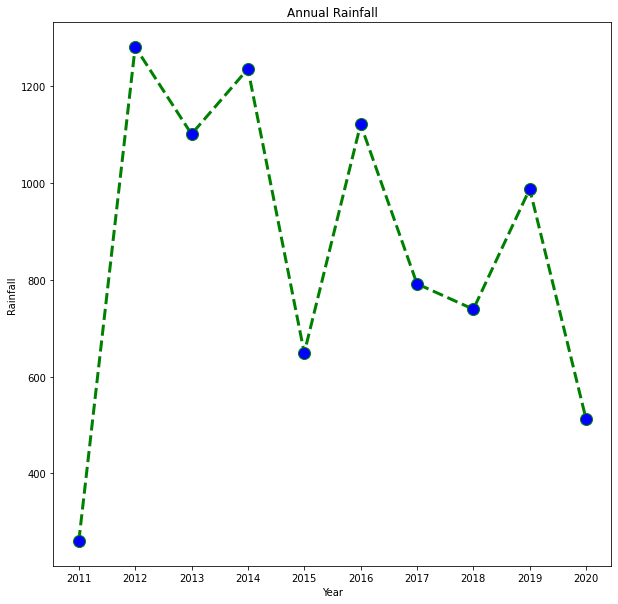

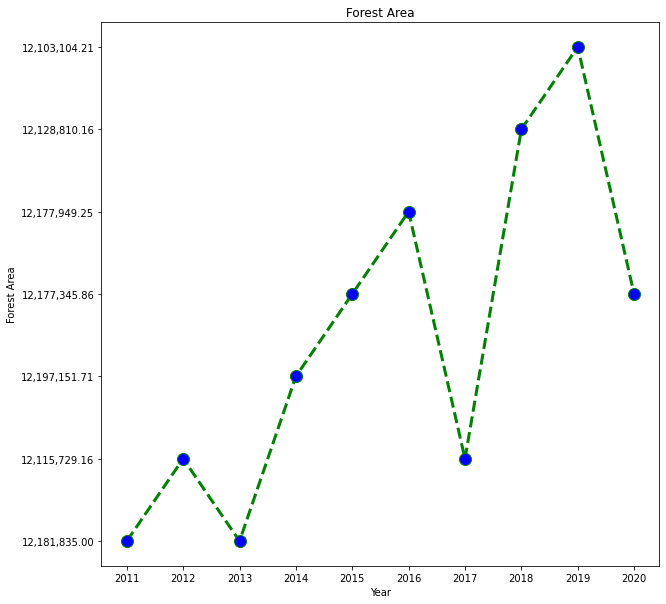

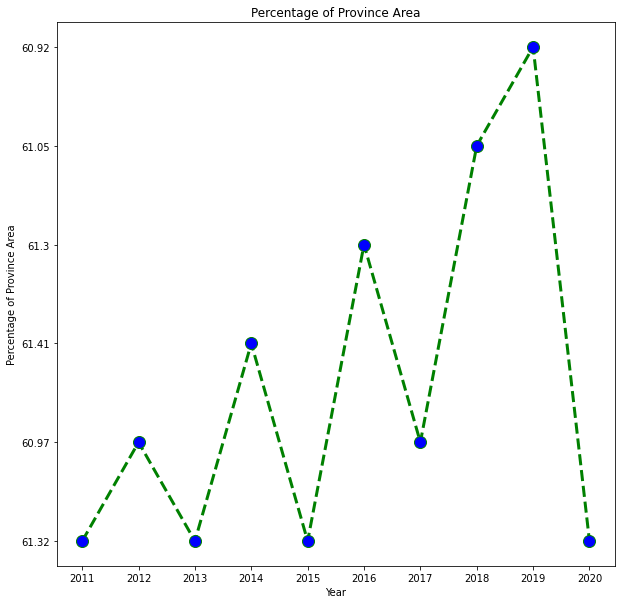

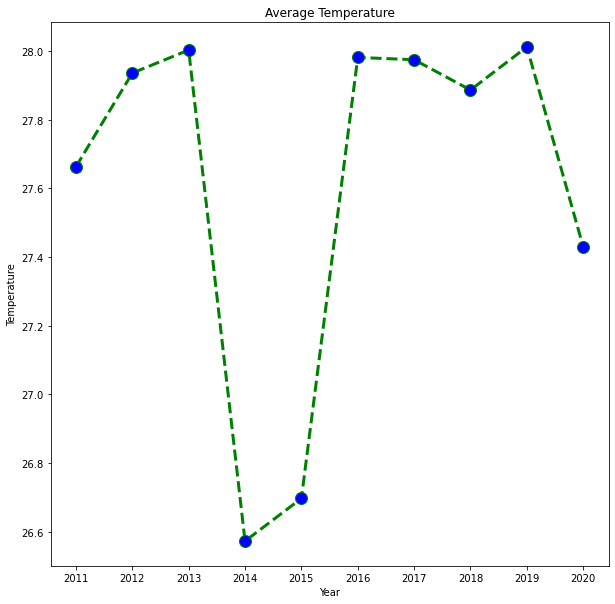

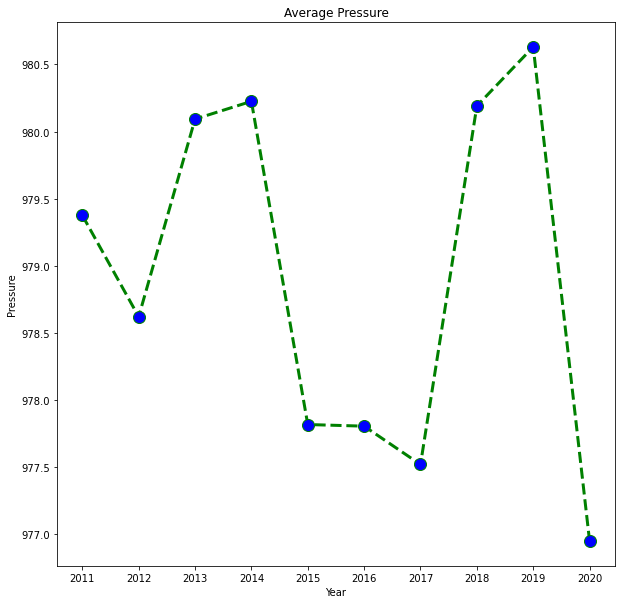

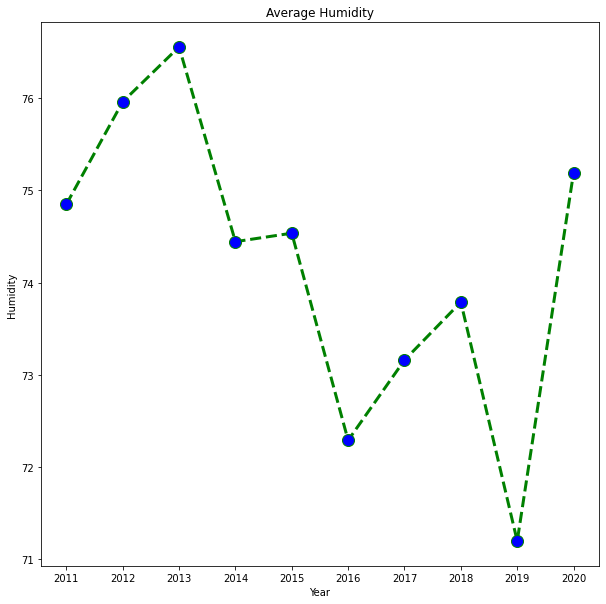

In [160]:
# plot graph north zone
plot(north_df_year['year'], north_df_year['rain1y'],"Annual Rainfall", "Year", "Rainfall")
print("\n")
plot(north_df_year['year'], north_df_year['Forest_Area'],"Forest Area", "Year", "Forest Area")
print("\n")
plot(north_df_year['year'], north_df_year['Percent_of_Province_Area'],"Percentage of Province Area", "Year", "Percentage of Province Area")
print("\n")
plot(north_df_year['year'], north_df_year['temp_out'],"Average Temperature", "Year", "Temperature")
print("\n")
plot(north_df_pyear['year'], north_df_pyear['press'],"Average Pressure", "Year", "Pressure")
print("\n")
plot(north_df_hyear['year'], north_df_hyear['humid'],"Average Humidity", "Year", "Humidity")

In [161]:
#สถานีตอนกลาง
mid_df_year = transformtoPerYear(mid_df)
mid_df_pyear = transformPresstoPerYear(mid_df)
mid_df_hyear = transformHumidtoPerYear(mid_df)
mid_yp = pd.merge(mid_df_year,mid_df_pyear,how='left',on =['index','rain1y','year','Key','code','Province_Area','Forest_Area','Percent_of_Province_Area','Non_Forest_Area'] )
mid = pd.merge(mid_yp,mid_df_hyear,how='left',on =['index','rain1y','year','Key','code','Province_Area','Forest_Area','Percent_of_Province_Area','Non_Forest_Area'])

display(mid)


,index,year,Key,code,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area,rain1y,temp_out,press,humid
0,0,2011,11,WCHN,"4,051,912.64","2,515,083.57",62.07,37.93,583.4,28.092610,995.393642,74.447205
1,1,2012,12,WCHN,"4,051,912.64","2,593,778.11",64.01,35.99,1529.0,28.768272,995.662181,72.513138
2,2,2013,13,WCHN,"4,051,912.64","2,515,083.57",62.07,37.93,1069.2,28.577500,997.786963,72.315788
3,3,2014,14,WCHN,"4,051,912.64","2,593,778.11",64.01,35.99,889.6,28.764943,996.829167,72.297603
4,4,2015,15,WCHN,"4,051,912.64","2,600,029.96",64.17,35.83,723.6,29.825525,994.488836,71.902169
5,5,2016,16,WCHN,"4,051,912.64","2,603,324.70",64.25,35.75,1216.6,28.690699,993.466735,72.531740
6,6,2017,17,WCHN,"4,051,912.64","2,610,863.30",64.44,35.56,1212.6,27.758436,992.695514,74.916301
7,7,2018,18,WCHN,"4,051,912.64","2,623,909.73",64.76,35.24,1157.0,27.730559,991.642637,76.704897
8,8,2019,19,WCHN,"4,051,912.64","2,627,401.47",64.84,35.16,891.2,28.176861,993.015205,76.257340
9,9,2020,20,WCHN,"4,051,912.64","2,593,778.11",64.01,35.99,762.4,27.209153,993.265323,79.524875


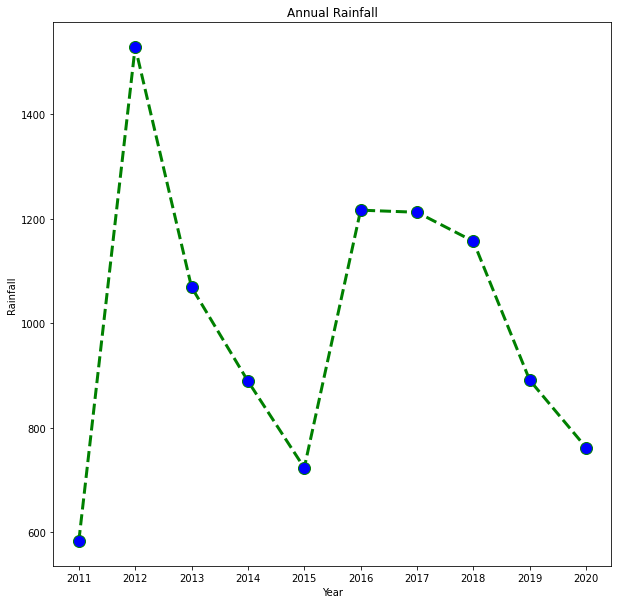

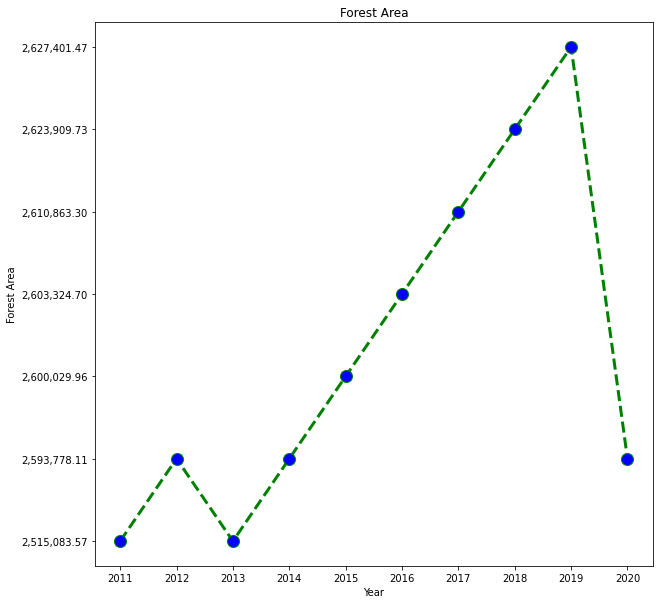

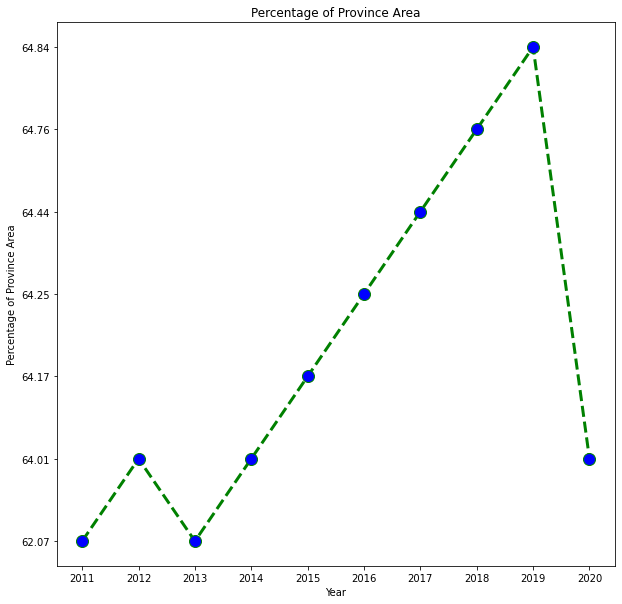

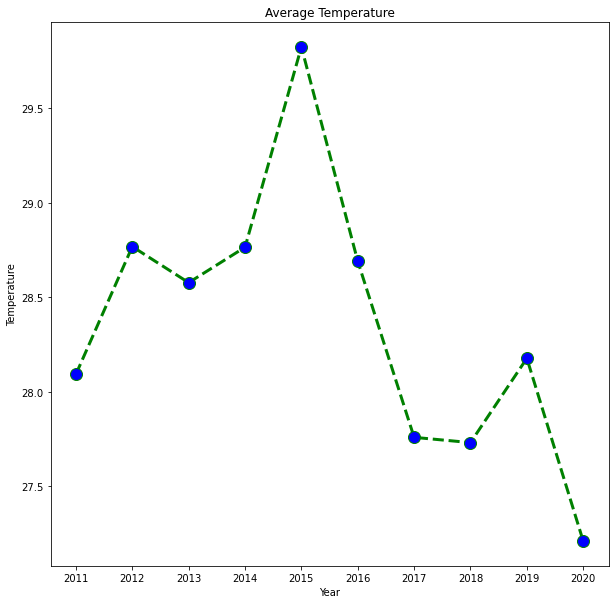

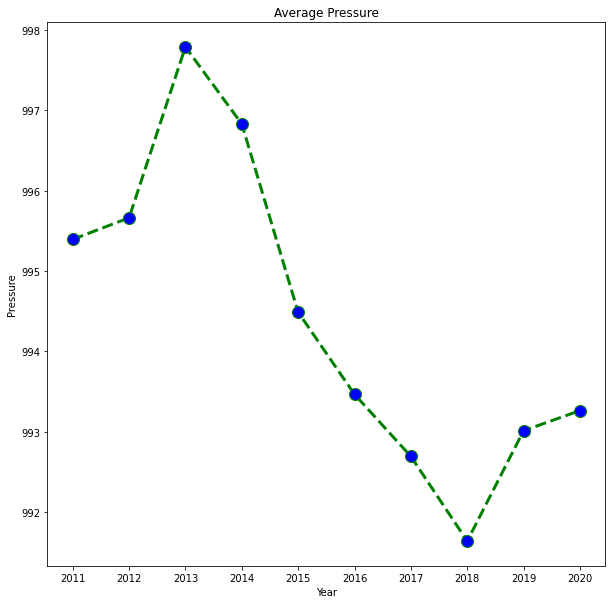

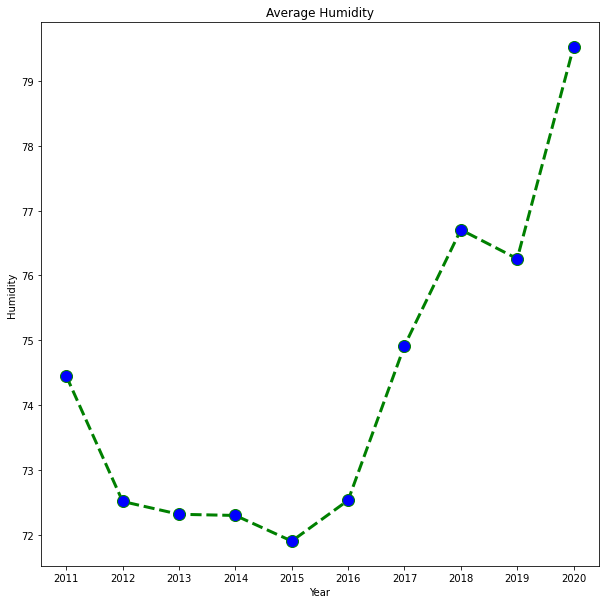

In [162]:
# plot graph mid zone
plot(mid_df_year['year'], mid_df_year['rain1y'],"Annual Rainfall", "Year", "Rainfall")
print("\n")
plot(mid_df_year['year'], mid_df_year['Forest_Area'],"Forest Area", "Year", "Forest Area")
print("\n")
plot(mid_df_year['year'], mid_df_year['Percent_of_Province_Area'],"Percentage of Province Area", "Year", "Percentage of Province Area")
print("\n")
plot(mid_df_year['year'], mid_df_year['temp_out'],"Average Temperature", "Year", "Temperature")
print("\n")
plot(mid_df_pyear['year'], mid_df_pyear['press'],"Average Pressure", "Year", "Pressure")
print("\n")
plot(mid_df_hyear['year'], mid_df_hyear['humid'],"Average Humidity", "Year", "Humidity")

In [163]:
#สถานีตอนล่าง
south_df_year = transformtoPerYear(south_df)
south_df_pyear = transformPresstoPerYear(south_df)
south_df_hyear = transformHumidtoPerYear(south_df)
south_yp = pd.merge(south_df_year,south_df_pyear,how='left',on =['index','rain1y','year','Key','code','Province_Area','Forest_Area','Percent_of_Province_Area','Non_Forest_Area'] )
south = pd.merge(south_yp,south_df_hyear,how='left',on =['index','rain1y','year','Key','code','Province_Area','Forest_Area','Percent_of_Province_Area','Non_Forest_Area'])
display(south)

,index,year,Key,code,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area,rain1y,temp_out,press,humid
0,0,2011,11,SWKL,"84,183,434.55","41,275,108.50",42.42,748.56,491.4,29.366855,1003.274654,66.566588
1,1,2012,12,SWKL,"84,183,434.55","41,652,816.09",43.38,736.0,935.6,31.145947,1001.606592,71.163411
2,2,2013,13,SWKL,"84,183,434.55","41,275,108.50",42.42,748.56,839.2,30.932968,1002.360126,69.094749
3,3,2014,14,SWKL,"84,183,434.55","41,746,553.35",43.47,734.86,1023.8,29.955023,1003.419760,69.923231
4,4,2015,15,SWKL,"84,183,434.55","41,719,510.41",43.44,735.31,492.8,30.192123,1001.835091,67.987854
5,5,2016,16,SWKL,"84,183,434.55","41,652,712.94",43.37,736.2,894.6,30.337580,1001.605100,65.771790
6,6,2017,17,SWKL,"84,183,434.55","41,652,816.09",43.38,736.0,1201.2,29.780297,1001.834281,70.804292
7,7,2018,18,SWKL,"84,183,434.55","41,728,212.55",43.51,734.36,730.4,29.315080,1002.257603,72.553813
8,8,2019,19,SWKL,"84,183,434.55","41,661,864.73",43.46,734.97,707.4,29.368858,1002.293116,71.064498
9,9,2020,20,SWKL,"84,183,434.55","41,661,864.73",43.46,734.97,751.8,28.930055,1002.321824,72.157104


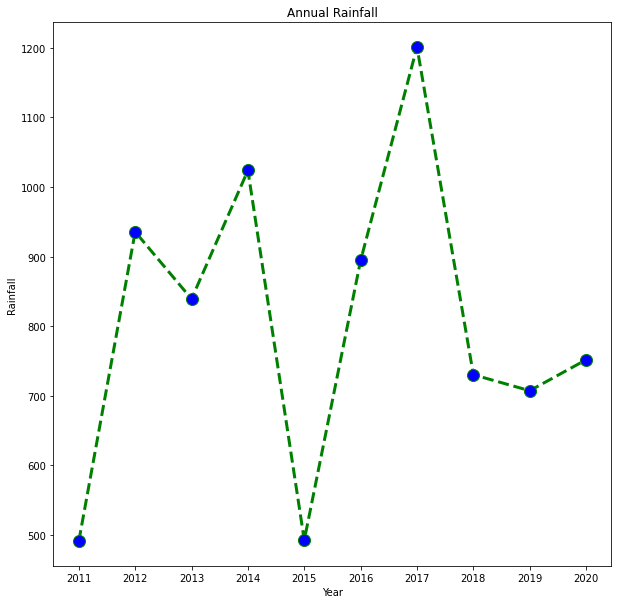

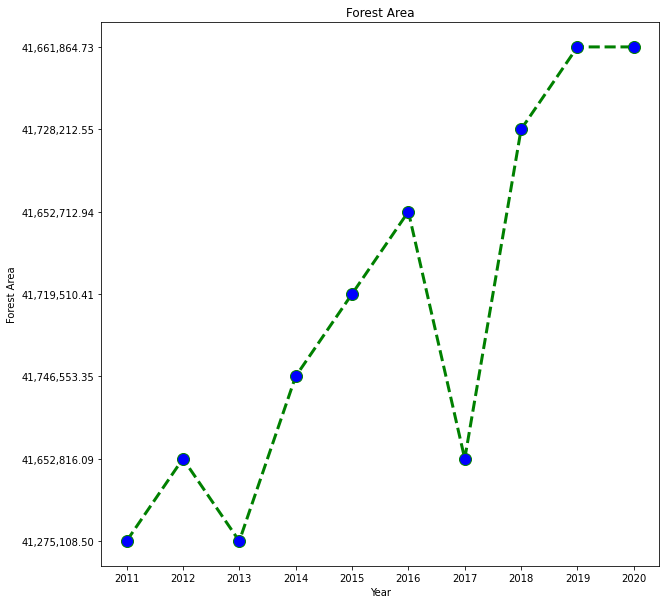

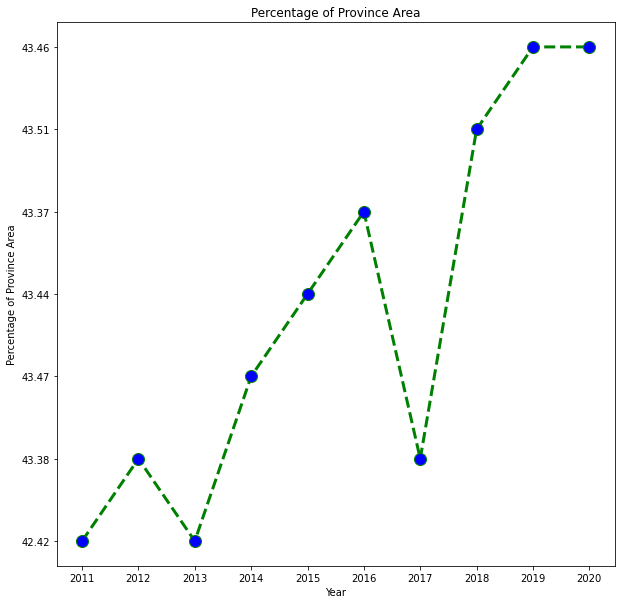

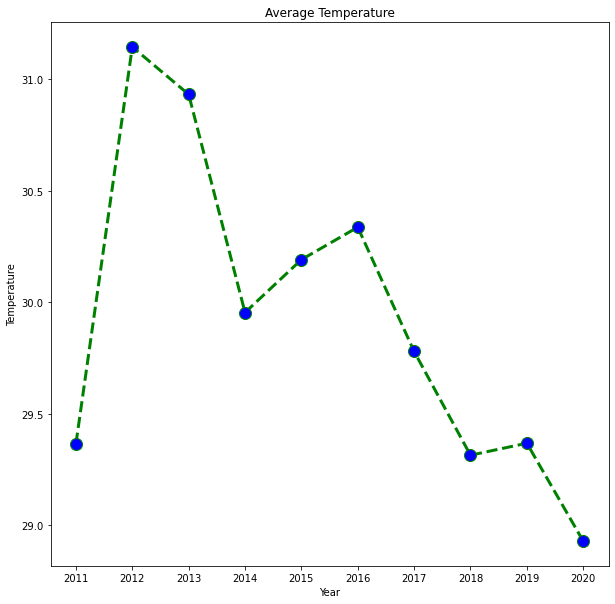

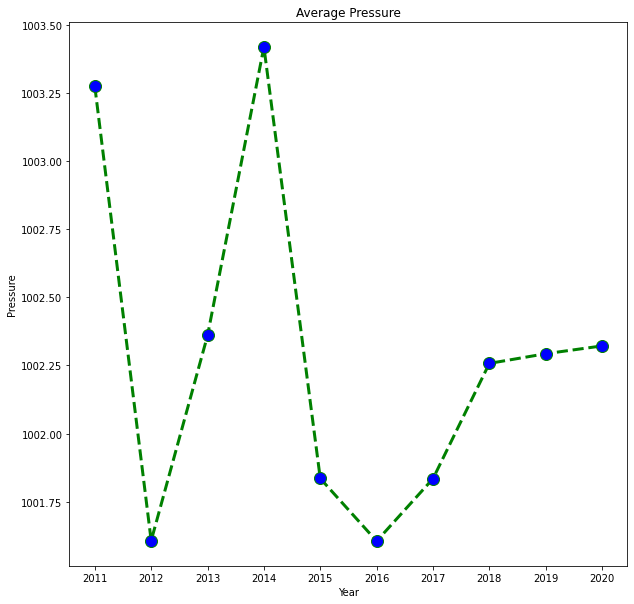

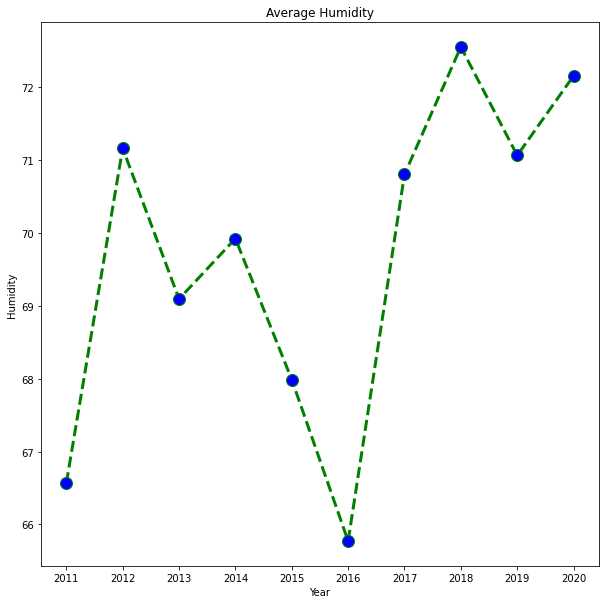

In [164]:
# plot south mid zone
plot(south_df_year['year'], south_df_year['rain1y'],"Annual Rainfall", "Year", "Rainfall")
print("\n")
plot(south_df_year['year'], south_df_year['Forest_Area'],"Forest Area", "Year", "Forest Area")
print("\n")
plot(south_df_year['year'], south_df_year['Percent_of_Province_Area'],"Percentage of Province Area", "Year", "Percentage of Province Area")
print("\n")
plot(south_df_year['year'], south_df_year['temp_out'],"Average Temperature", "Year", "Temperature")
print("\n")
plot(south_df_pyear['year'], south_df_pyear['press'],"Average Pressure", "Year", "Pressure")
print("\n")
plot(south_df_hyear['year'], south_df_hyear['humid'],"Average Humidity", "Year", "Humidity")

##Season Time Series



In [165]:
#set index
def transform_index(dataframe):
  df = dataframe.copy()
  #df['Date'] = pd.to_datetime(df['Date'])
  df = df.set_index('Date')
  return df


อนุกรมเวลาสถานีตอนบน: สถานีทต.เชียงม่วน

อนุกรมเวลาสถานีตอนบน: สถานีทต.เชียงม่วน


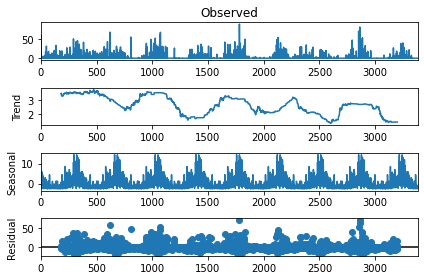

In [166]:
rain_season_n = transform_index(north_df)
rain_decom_n = seasonal_decompose(rain_season_n['rain1d'].values, model='additive', freq= 365)

print('อนุกรมเวลาสถานีตอนบน: สถานีทต.เชียงม่วน')
rain_decom_n.plot()
plt.show()
plt.close()


อนุกรมเวลาสถานีตอนกลาง: สถานีอบต.วังชิ้น

อนุกรมเวลาสถานีตอนกลาง: สถานีอบต.วังชิ้น


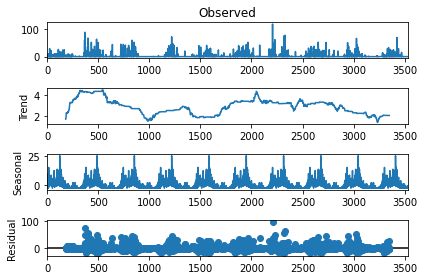

In [167]:
rain_season_m = transform_index(mid_df)
rain_decom_m = seasonal_decompose(rain_season_m['rain1d'].values, model='additive', freq= 365)

print('อนุกรมเวลาสถานีตอนกลาง: สถานีอบต.วังชิ้น')
rain_decom_m.plot()
plt.show()
plt.close()

อนุกรมเวลาสถานีตอนล่าง: สถานีโรงฆ่าสัตว์ ทม.สวรรคโลก

อนุกรมเวลาสถานีตอนล่าง: สถานีโรงฆ่าสัตว์ ทม.สวรรคโลก


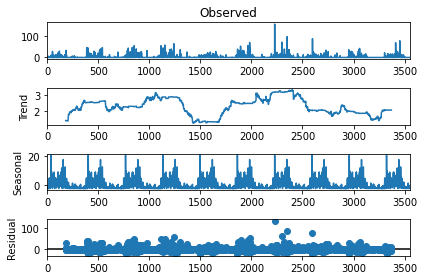

In [168]:
rain_season_s = transform_index(south_df)
rain_decom_s = seasonal_decompose(rain_season_s['rain1d'].values, model='additive', freq= 365)

print('อนุกรมเวลาสถานีตอนล่าง: สถานีโรงฆ่าสัตว์ ทม.สวรรคโลก')
rain_decom_s.plot()
plt.show()
plt.close()

#Data Modeling

In [169]:
#Check Stationarity Data
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:", dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t{}: {} - The data is {} stationary with {}% confidence".format(key, val
         , "not" if val<dftest[0] else "", 100-int(key[:-1])))

In [170]:
ad_test(north_df['rain1d'])

1. ADF :  -6.917608944197283
2. P-Value :  1.168515472678681e-09
3. Num Of Lags :  26
4. Num Of Observations Used For ADF Regression: 3355
5. Critical Values :
	1%: -3.4323006141089776 - The data is  stationary with 99% confidence
	5%: -2.86240186752734 - The data is  stationary with 95% confidence
	10%: -2.567228789048532 - The data is  stationary with 90% confidence


In [171]:
ad_test(mid_df['rain1d'])

1. ADF :  -5.9552670506424334
2. P-Value :  2.100542165234618e-07
3. Num Of Lags :  30
4. Num Of Observations Used For ADF Regression: 3500
5. Critical Values :
	1%: -3.43221974356695 - The data is  stationary with 99% confidence
	5%: -2.8623661465665307 - The data is  stationary with 95% confidence
	10%: -2.5672097721632654 - The data is  stationary with 90% confidence


In [172]:
ad_test(south_df['rain1d'])

1. ADF :  -9.004785003047061
2. P-Value :  6.354784581422205e-15
3. Num Of Lags :  17
4. Num Of Observations Used For ADF Regression: 3535
5. Critical Values :
	1%: -3.432201217785406 - The data is  stationary with 99% confidence
	5%: -2.862357963491113 - The data is  stationary with 95% confidence
	10%: -2.567205415735552 - The data is  stationary with 90% confidence


##Model Selection
Evaluate 3 model with univariate data and use RMSE(root mean square error) for selecting the best fit
In this selecting method we'll use only north_data as an example data because its stationary data and season when decomposed has similar with the other two.

In [173]:
def train_test_split(df, train_size=0.8, transform=True):
  train_data = df[['Date','rain1d']].iloc[:(int)(len(df)*train_size)]
  test_data = df[['Date','rain1d']].iloc[(int)(len(df)*train_size):]
  if transform:
    train_data = transform_index(train_data)
    test_data = transform_index(test_data)
  return train_data, test_data

In [174]:
train_data_ex, test_data_ex = train_test_split(north_df)

In [175]:
north_df.shape

(3382, 12)

In [176]:
train_data_ex.shape

(2705, 1)

In [177]:
test_data_ex.shape

(677, 1)

###SARIMA

In [180]:
north_df_new = transform_index(north_df)
auto_arima(north_df_new['rain1d']).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3382
Model:               SARIMAX(2, 1, 3)   Log Likelihood              -11390.242
Date:                Wed, 09 Jun 2021   AIC                          22792.484
Time:                        11:58:33   BIC                          22829.239
Sample:                             0   HQIC                         22805.624
                               - 3382                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7205      0.078     -9.180      0.000      -0.874      -0.567
ar.L2         -0.7287      0.080     -9.084      0.000      -0.886      -0.571
ma.L1         -0.1848      0.073     -2.527      0.011      -0.328      -0.041
ma.L2          0.0247      0.076      0.327      0.744      -0.123       0.173
ma.L3         -0.7332      0.073    -10.038      0.000      -0.876      -0.590
sigma2        49.3657      0.337    146.423      0.000      48.705      50.026
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):            148512.70
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                             4.64
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [181]:
sarima_model = SARIMAX(train_data_ex['rain1d'], order = (2,1,3))
sarima_result = sarima_model.fit()
sarima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 rain1d   No. Observations:                 2705
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -9075.991
Date:                Wed, 09 Jun 2021   AIC                          18163.981
Time:                        11:58:36   BIC                          18199.396
Sample:                    09-29-2011   HQIC                         18176.787
                         - 02-23-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6799      0.133     -5.125      0.000      -0.940      -0.420
ar.L2         -0.6912      0.128     -5.385      0.000      -0.943      -0.440
ma.L1         -0.2415      0.126     -1.911      0.056      -0.489       0.006
ma.L2          0.0384      0.118      0.327      0.744      -0.192       0.269
ma.L3         -0.6993      0.120     -5.839      0.000      -0.934      -0.465
sigma2        47.6730      0.359    132.655      0.000      46.969      48.377
===================================================================================
Ljung-Box (L1) (Q):                   0.64   Jarque-Bera (JB):             94653.26
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                             4.38
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [182]:
sarima_pred = sarima_result.predict(start = len(train_data_ex), end = len(north_df_new)-1, typ="levels").rename("SARIMA Predictions")
sarima_pred

2019-02-24    0.140107
2019-02-25    0.145920
2019-02-26    0.148163
2019-02-27    0.142620
2019-02-28    0.144839
                ...   
2020-12-27    0.145172
2020-12-28    0.145172
2020-12-29    0.145172
2020-12-30    0.145172
2020-12-31    0.145172
Freq: D, Name: SARIMA Predictions, Length: 677, dtype: float64

In [183]:
test_data_ex['SARIMA_Predictions'] = sarima_pred
#Rainfall cannot be negative
test_data_ex.loc[(test_data_ex['SARIMA_Predictions'] < 0.0),'SARIMA_Predictions']= 0.0

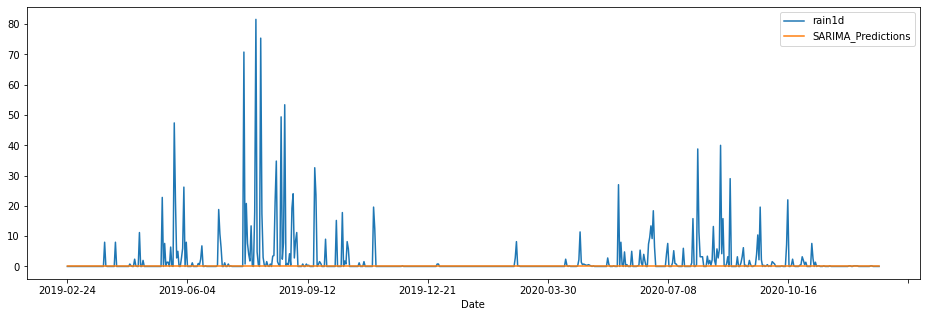

In [184]:
test_data_ex['rain1d'].plot(figsize = (16,5), legend=True)
test_data_ex['SARIMA_Predictions'].plot(legend = True);

In [185]:
sarima_rmse_error = rmse(test_data_ex['rain1d'], sarima_pred)
print('SARIMA Prediction')
print('RMSE Error: '+str(sarima_rmse_error))

SARIMA Prediction
RMSE Error: 7.931100742576371


###Facebook Prophet

In [186]:
#Prepare data
train_data_p, test_data_p = train_test_split(north_df ,transform=False)
train_data_p = train_data_p[['Date', 'rain1d']]
test_data_p = test_data_p[['Date', 'rain1d']]
train_data_p = train_data_p.rename(columns={'Date':'ds', 'rain1d':'y'})
test_data_p = test_data_p.rename(columns={'Date':'ds', 'rain1d':'y'})

In [187]:
test_data_p.tail()

,ds,y
3377,2020-12-27,0.0
3378,2020-12-28,0.0
3379,2020-12-29,0.0
3380,2020-12-30,0.0
3381,2020-12-31,0.0


In [188]:
m = Prophet()
m.fit(train_data_p)
future = m.make_future_dataframe(periods=len(test_data_p),freq='D')
prophet_pred = m.predict(future)
prophet_pred.tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3377,2020-12-27,1.396482,-9.578492,7.492156,1.363498,1.429530,-2.139719,-2.139719,-2.139719,-0.401282,-0.401282,-0.401282,-1.738436,-1.738436,-1.738436,0.0,0.0,0.0,-0.743237
3378,2020-12-28,1.395788,-9.790290,7.913535,1.362660,1.428885,-2.128090,-2.128090,-2.128090,-0.382019,-0.382019,-0.382019,-1.746071,-1.746071,-1.746071,0.0,0.0,0.0,-0.732302
3379,2020-12-29,1.395094,-9.508351,8.553872,1.361821,1.428239,-1.378985,-1.378985,-1.378985,0.368308,0.368308,0.368308,-1.747293,-1.747293,-1.747293,0.0,0.0,0.0,0.016109
3380,2020-12-30,1.394400,-9.195372,8.305055,1.360983,1.427619,-1.790676,-1.790676,-1.790676,-0.048733,-0.048733,-0.048733,-1.741943,-1.741943,-1.741943,0.0,0.0,0.0,-0.396276
3381,2020-12-31,1.393706,-9.338128,8.035680,1.360144,1.427052,-2.003501,-2.003501,-2.003501,-0.273415,-0.273415,-0.273415,-1.730086,-1.730086,-1.730086,0.0,0.0,0.0,-0.609794


In [189]:
ph_pred = prophet_pred[['ds','yhat']].iloc[-1*len(test_data_p):]
ph_pred

,ds,yhat
2705,2019-02-24,0.017042
2706,2019-02-25,-0.028644
2707,2019-02-26,0.649015
2708,2019-02-27,0.153285
2709,2019-02-28,-0.154177
...,...,...
3377,2020-12-27,-0.743237
3378,2020-12-28,-0.732302
3379,2020-12-29,0.016109
3380,2020-12-30,-0.396276


In [190]:
ph_pred = ph_pred.rename(columns={'ds':'Date', 'yhat':'rain1d'})
ph_pred = transform_index(ph_pred)
ph_pred.tail()

,rain1d
Date,
2020-12-27,-0.743237
2020-12-28,-0.732302
2020-12-29,0.016109
2020-12-30,-0.396276
2020-12-31,-0.609794


In [191]:
test_data_ex['Prophet_Prediction'] = ph_pred['rain1d']

In [192]:
#Rainfall cannot be negative
test_data_ex.loc[(test_data_ex['Prophet_Prediction'] < 0.0),'Prophet_Prediction']= 0.0

In [193]:
test_data_ex.head(3)

,rain1d,SARIMA_Predictions,Prophet_Prediction
Date,,,
2019-02-24,0.0,0.140107,0.017042
2019-02-25,0.0,0.145920,0.000000
2019-02-26,0.0,0.148163,0.649015


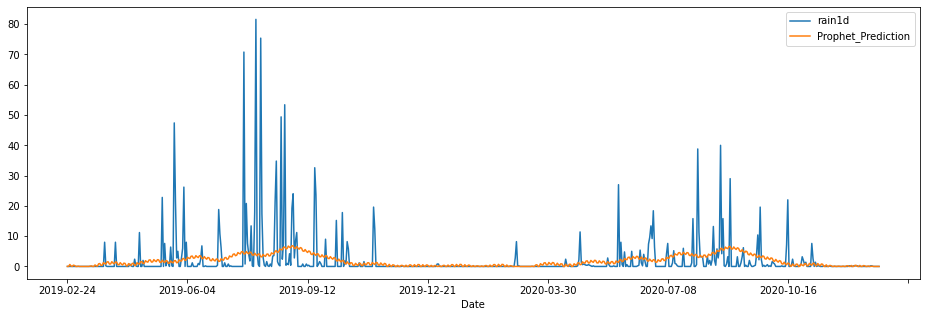

In [194]:
test_data_ex['rain1d'].plot(figsize = (16,5), legend=True)
test_data_ex['Prophet_Prediction'].plot(legend = True);

In [195]:
prophet_rmse_error = rmse(test_data_ex['rain1d'], test_data_ex['Prophet_Prediction'])
print('Prophet Prediction')
print('RMSE Error: '+str(prophet_rmse_error))

Prophet Prediction
RMSE Error: 7.390506371320148


###LSTM

In [196]:
#Preprocessing data for using in LSTM
scaler = MinMaxScaler()
scaler.fit(train_data_ex)
scaled_train_data = scaler.transform(train_data_ex)
scaled_test_data = scaler.transform(test_data_ex)

In [197]:
n_input = len(test_data_ex)
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=32)

lstm_model = Sequential()
lstm_model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10)                480       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [198]:
lstm_model.fit_generator(generator,epochs=10)

Epoch 1/10
64/64 [==============================] - 35s 190ms/step - loss: 0.0054
Epoch 2/10
64/64 [==============================] - 12s 191ms/step - loss: 0.0065
Epoch 3/10
64/64 [==============================] - 12s 193ms/step - loss: 0.0054
Epoch 4/10
64/64 [==============================] - 13s 200ms/step - loss: 0.0067
Epoch 5/10
64/64 [==============================] - 12s 191ms/step - loss: 0.0060
Epoch 6/10
64/64 [==============================] - 12s 190ms/step - loss: 0.0057
Epoch 7/10
64/64 [==============================] - 12s 190ms/step - loss: 0.0053
Epoch 8/10
64/64 [==============================] - 12s 189ms/step - loss: 0.0064
Epoch 9/10
64/64 [==============================] - 12s 189ms/step - loss: 0.0049
Epoch 10/10
64/64 [==============================] - 12s 188ms/step - loss: 0.0053


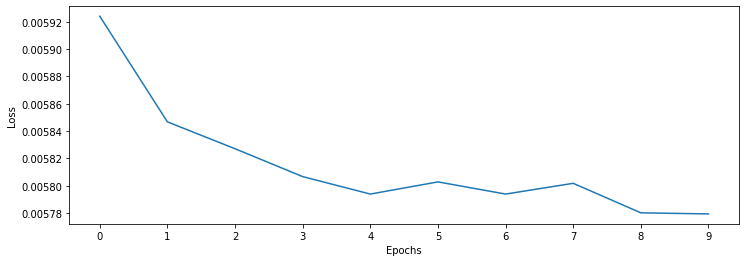

In [199]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [200]:
lstm_predictions_scaled = []

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data_ex)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [201]:
#inverse to regular values
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
test_data_ex['LSTM_Prediction'] = lstm_predictions
#Rainfall cannot be negative
test_data_ex.loc[(test_data_ex['LSTM_Prediction'] < 0.0),'LSTM_Prediction']= 0.0

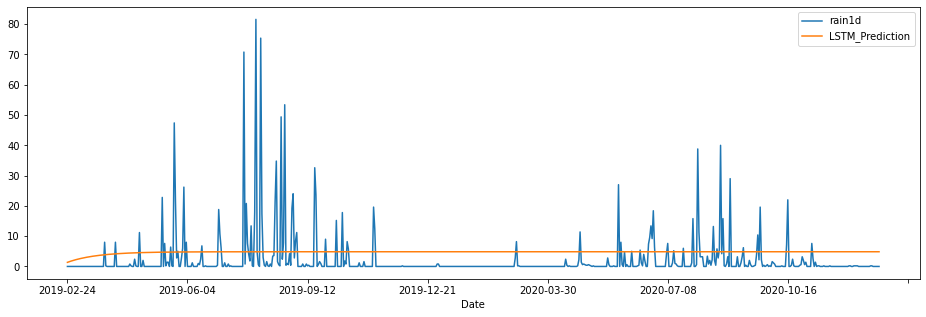

In [202]:
test_data_ex['rain1d'].plot(figsize = (16,5), legend=True)
test_data_ex['LSTM_Prediction'].plot(legend = True);

In [203]:
lstm_rmse_error = rmse(test_data_ex['rain1d'], test_data_ex['LSTM_Prediction'])
print('LSTM Prediction')
print('RMSE Error: '+str(lstm_rmse_error))

LSTM Prediction
RMSE Error: 8.05345550559279


###Model Comparison

In [204]:
test_data_ex.dtypes

rain1d                float64
SARIMA_Predictions    float64
Prophet_Prediction    float64
LSTM_Prediction       float64
dtype: object

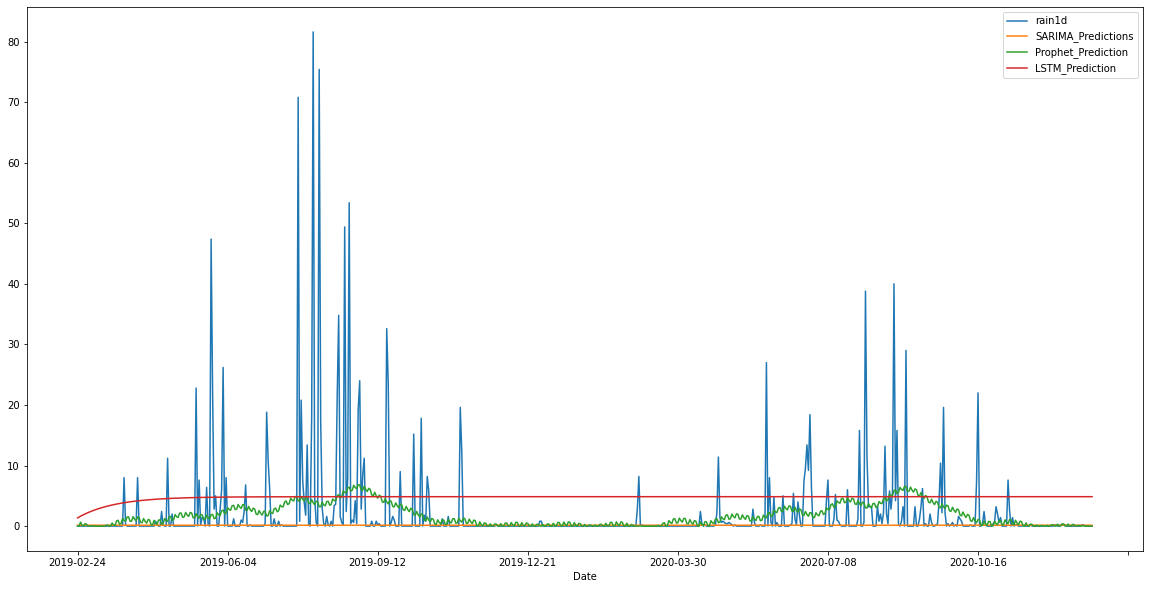

In [205]:
test_data_ex['rain1d'].plot(figsize = (20,10), legend=True)
test_data_ex['SARIMA_Predictions'].plot(legend = True)
test_data_ex['Prophet_Prediction'].plot(legend = True)
test_data_ex['LSTM_Prediction'].plot(legend = True)

In [206]:
print('SARIMA RMSE: '+str(sarima_rmse_error))
print('Prophet RMSE: '+str(prophet_rmse_error))
print('LSTM RMSE: '+str(lstm_rmse_error))

SARIMA RMSE: 7.931100742576371
Prophet RMSE: 7.390506371320148
LSTM RMSE: 8.05345550559279


##Setting Model
Data Preprocessing

In [207]:
def change_type(df):
  col = ['Forest_Area', 'Province_Area', 'Non_Forest_Area', 'Percent_of_Province_Area']
  for i in col:
    df[i] = df[i].apply(lambda x : x.replace(',', ''))
    df[i] = df[i].astype(float)
  return df

In [208]:
def train_test_split_prophet(df, train_size=0.8):
  df_new = df.copy()
  df_new = df_new.drop(columns=['Key','code'])
  train_data = df_new.iloc[:(int)(len(df)*train_size)]
  test_data = df_new.iloc[(int)(len(df)*train_size):]
  train_data = train_data.rename(columns={'Date':'ds', 'rain1d':'y'})
  test_data = test_data.rename(columns={'Date':'ds', 'rain1d':'y'})
  return train_data, test_data

In [209]:
north_df = change_type(north_df)

In [210]:
north_df.dtypes

Date                         object
Key                          object
code                         object
Province_Area               float64
Forest_Area                 float64
Percent_of_Province_Area    float64
Non_Forest_Area             float64
temp_out                    float64
press                       float64
humid                       float64
rain1d                      float64
year                         object
dtype: object

In [211]:
train_data_n, test_data_n = train_test_split_prophet(north_df)

###Multivariate values

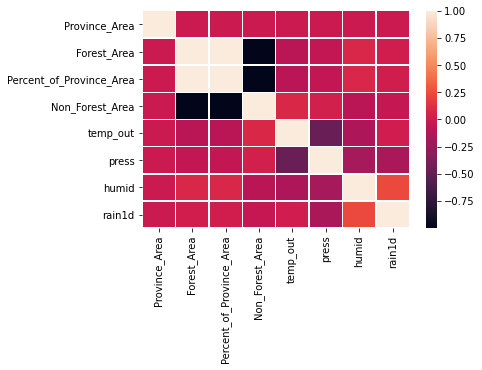

In [212]:
corr_data = north_df.corr()
ax = sns.heatmap(corr_data, linewidth=0.5)
plt.show()

In [213]:
m = Prophet()
m.add_regressor('Forest_Area')
m.add_regressor('temp_out')
m.add_regressor('press')
m.add_regressor('humid')
m.fit(train_data_n)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [214]:
future_n = m.make_future_dataframe(periods = len(test_data_n))
future_n['Forest_Area'] = north_df['Forest_Area']
future_n['temp_out'] = north_df['temp_out']
future_n['press'] = north_df['press']
future_n['humid'] = north_df['humid']

In [215]:
forecast_n = m.predict(future_n)

In [216]:
#Rainfall cannot be negative
forecast_n = forecast_n[['ds','yhat']].iloc[len(train_data_n):]
forecast_n['Actual_Rainfall'] = np.array(test_data_n['y'])
forecast_n = forecast_n.rename(columns={'ds':'Date', 'yhat':'Rainfall_Prediction'})
forecast_n.loc[(forecast_n['Rainfall_Prediction'] < 0.0),'Rainfall_Prediction']= 0.0
forecast_n = transform_index(forecast_n)

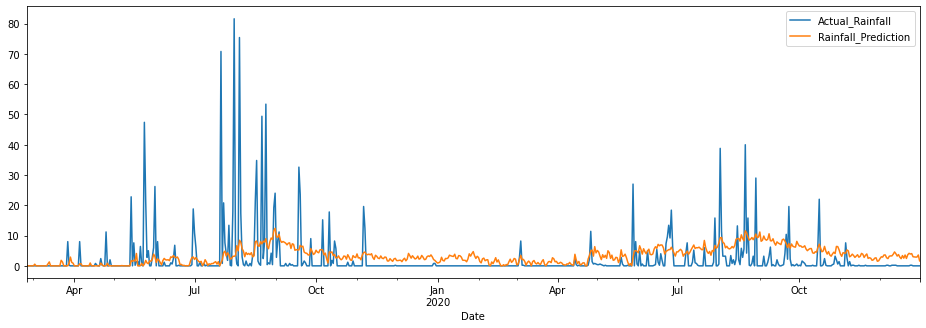

In [217]:
forecast_n['Actual_Rainfall'].plot(figsize = (16,5), legend=True)
forecast_n['Rainfall_Prediction'].plot(legend = True);

In [218]:
prophet_rmse_error_n = rmse(forecast_n['Actual_Rainfall'], forecast_n['Rainfall_Prediction'])
print('Prophet Prediction')
print('RMSE Error: '+str(prophet_rmse_error_n))

Prophet Prediction
RMSE Error: 7.531717974587441


###Feature Engineering

In [219]:
# Create feature_engineer function to extract new features
def feature_engineer(df):
  dataframe = df.copy()
  col =  ['Forest_Area', 'temp_out', 'press', 'humid', 'rain1d']
  for i in col:
    dataframe['Previous'+i] = dataframe[[i]].shift(periods=1,fill_value=0)
  return dataframe

In [220]:
north_df_eng = feature_engineer(north_df)
north_df_eng.tail()

,Date,Key,code,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area,temp_out,press,humid,rain1d,year,PreviousForest_Area,Previoustemp_out,Previouspress,Previoushumid,Previousrain1d
3377,2020-12-27,20,CGMN,19254452.3,12177949.25,61.30,116.11,25.029167,978.312500,76.641667,0.0,2020,12128810.16,24.345833,979.300000,74.554167,0.0
3378,2020-12-28,20,CGMN,19254452.3,12177345.86,61.32,116.03,25.291667,977.179167,75.895833,0.0,2020,12177949.25,25.029167,978.312500,76.641667,0.0
3379,2020-12-29,20,CGMN,19254452.3,12128810.16,61.05,116.86,24.054167,978.066667,71.870833,0.0,2020,12177345.86,25.291667,977.179167,75.895833,0.0
3380,2020-12-30,20,CGMN,19254452.3,12197151.71,61.41,115.77,21.416667,980.754167,75.412500,0.0,2020,12128810.16,24.054167,978.066667,71.870833,0.0
3381,2020-12-31,20,CGMN,19254452.3,12181835.00,61.32,116.05,23.087500,982.700000,70.308333,0.0,2020,12197151.71,21.416667,980.754167,75.412500,0.0


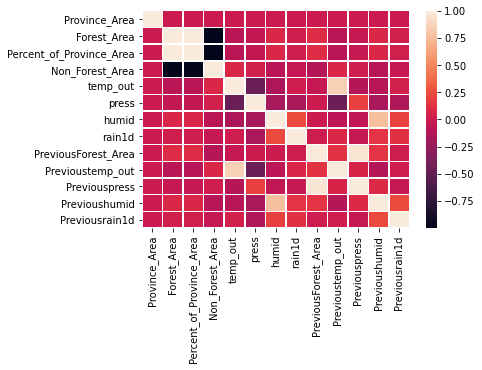

In [221]:
corr_data_eng = north_df_eng.corr()
ax = sns.heatmap(corr_data_eng, linewidth=0.5)
plt.show()

In [222]:
train_data_n_eng, test_data_n_eng = train_test_split_prophet(north_df_eng)
train_data_n_eng.tail()

,ds,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area,temp_out,press,humid,y,year,PreviousForest_Area,Previoustemp_out,Previouspress,Previoushumid,Previousrain1d
2700,2019-02-19,19254452.3,12103104.21,60.92,117.24,28.645833,982.791667,59.333333,0.0,2019,12103104.21,29.250000,980.666667,63.583333,0.0
2701,2019-02-20,19254452.3,12103104.21,60.92,117.24,28.975000,984.750000,61.333333,0.0,2019,12103104.21,28.645833,982.791667,59.333333,0.0
2702,2019-02-21,19254452.3,12103104.21,60.92,117.24,26.100000,984.666667,68.650000,0.0,2019,12103104.21,28.975000,984.750000,61.333333,0.0
2703,2019-02-22,19254452.3,12103104.21,60.92,117.24,27.154167,981.583333,72.158333,0.0,2019,12103104.21,26.100000,984.666667,68.650000,0.0
2704,2019-02-23,19254452.3,12103104.21,60.92,117.24,26.970833,980.541667,61.625000,0.0,2019,12103104.21,27.154167,981.583333,72.158333,0.0


In [223]:
m = Prophet()
m.add_regressor('Forest_Area')
m.add_regressor('temp_out')
m.add_regressor('press')
m.add_regressor('humid')
m.add_regressor('PreviousForest_Area')
m.add_regressor('Previoustemp_out')
m.add_regressor('Previouspress')
m.add_regressor('Previoushumid')
m.add_regressor('Previousrain1d')
m.fit(train_data_n_eng)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [224]:
future_n_eng = m.make_future_dataframe(periods = len(test_data_n_eng))
future_n_eng['Forest_Area'] = north_df_eng['Forest_Area']
future_n_eng['temp_out'] = north_df_eng['temp_out']
future_n_eng['press'] = north_df_eng['press']
future_n_eng['humid'] = north_df_eng['humid']
future_n_eng['PreviousForest_Area'] = north_df_eng['PreviousForest_Area']
future_n_eng['Previoustemp_out'] = north_df_eng['Previoustemp_out']
future_n_eng['Previouspress'] = north_df_eng['Previouspress']
future_n_eng['Previoushumid'] = north_df_eng['Previoushumid']
future_n_eng['Previousrain1d'] = north_df_eng['Previousrain1d']

In [225]:
forecast_n_eng = m.predict(future_n_eng)

In [226]:
#Rainfall cannot be negative
forecast_n_eng = forecast_n_eng[['ds','yhat']].iloc[len(train_data_n_eng):]
forecast_n_eng['Actual_Rainfall'] = np.array(test_data_n_eng['y'])
forecast_n_eng = forecast_n_eng.rename(columns={'ds':'Date', 'yhat':'Rainfall_Prediction_eng'})
forecast_n_eng.loc[(forecast_n_eng['Rainfall_Prediction_eng'] < 0.0),'Rainfall_Prediction_eng']= 0.0
forecast_n_eng = transform_index(forecast_n_eng)

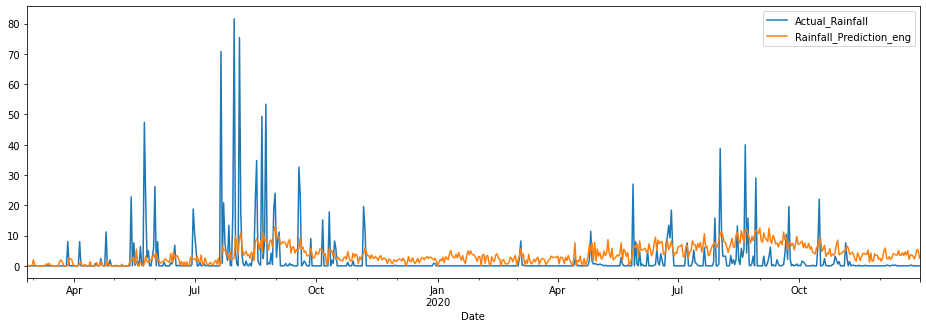

In [227]:
forecast_n_eng['Actual_Rainfall'].plot(figsize = (16,5), legend=True)
forecast_n_eng['Rainfall_Prediction_eng'].plot(legend = True);

In [228]:
prophet_rmse_error_n_eng = rmse(forecast_n['Actual_Rainfall'], forecast_n_eng['Rainfall_Prediction_eng'])
print('Prophet Prediction after feature engineering')
print('RMSE Error: '+str(prophet_rmse_error_n_eng))

Prophet Prediction after feature engineering
RMSE Error: 7.639235945248867


###Prophet model comparison

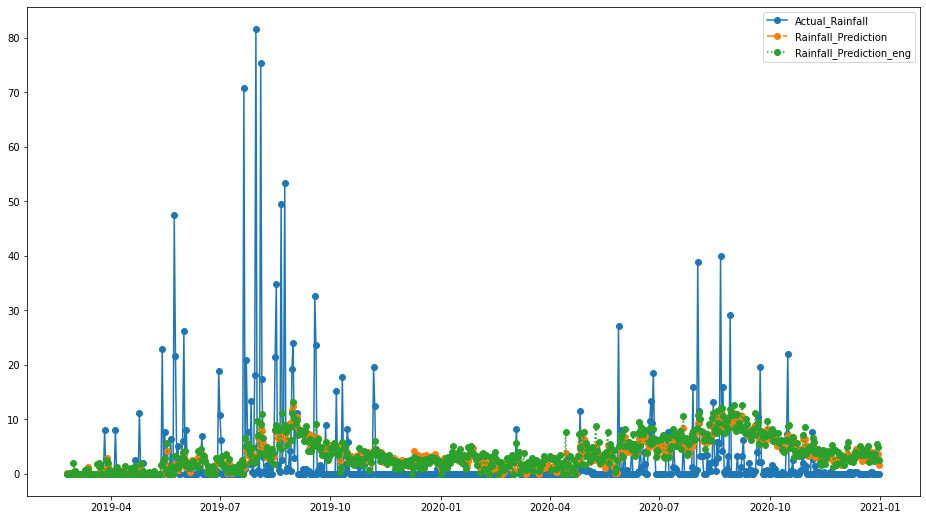

In [229]:
plt.figure(figsize=(16,9))
plt.plot_date(forecast_n.index, forecast_n['Actual_Rainfall'], linestyle="-")
plt.plot_date(forecast_n.index, forecast_n['Rainfall_Prediction'], linestyle="-.")
plt.plot_date(forecast_n.index, forecast_n_eng['Rainfall_Prediction_eng'], linestyle=":")
plt.legend(['Actual_Rainfall', 'Rainfall_Prediction', 'Rainfall_Prediction_eng'])
plt.show()

In [230]:
print('Prophet Prediction with univariate values')
print('RMSE Error: '+str(prophet_rmse_error))
print('Prophet Prediction with multivariate values')
print('RMSE Error: '+str(prophet_rmse_error_n))
print('Prophet Prediction with multivariate values after feature engineering')
print('RMSE Error: '+str(prophet_rmse_error_n_eng))

Prophet Prediction with univariate values
RMSE Error: 7.390506371320148
Prophet Prediction with multivariate values
RMSE Error: 7.531717974587441
Prophet Prediction with multivariate values after feature engineering
RMSE Error: 7.639235945248867


##Model Execution
Forecasting rainfall

In [231]:
def forecast_model(df, period, freq):
  #Preprocessing
  df_new = df[['Date', 'rain1d']]
  df_new = df_new.rename(columns={'Date':'ds', 'rain1d':'y'})
  #Modeling
  m = Prophet()
  m.fit(df_new)
  future = m.make_future_dataframe(periods=period, freq= freq)
  prophet_pred = m.predict(future)
  prophet_pred.loc[(prophet_pred['yhat'] < 0.0),'yhat']= 0.0
  return prophet_pred, m

###North station
สถานีทต.เชียงม่วน

1 Year later

In [232]:
forecast_n2021, model_n2021 = forecast_model(north_df, 365, 'D')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ปริมาณฝนสะสมลุ่มแม่น้ำยมตอนบนจากการทำนายปี ค.ศ. 2011-2021


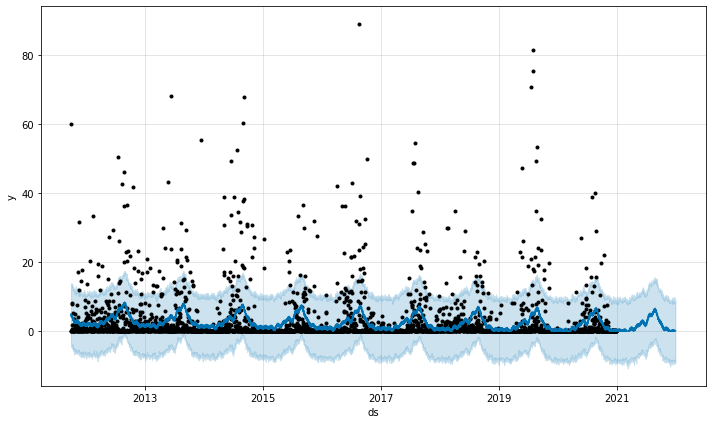

In [233]:
model_n2021.plot(forecast_n2021)
print('ปริมาณฝนสะสมลุ่มแม่น้ำยมตอนบนจากการทำนายปี ค.ศ. 2011-2021')
plt.show()
plt.close()

องค์ประกอบของปริมาณฝนสะสมลุ่มแม่น้ำยมตอนบนจากการทำนายปี ค.ศ. 2011-2021


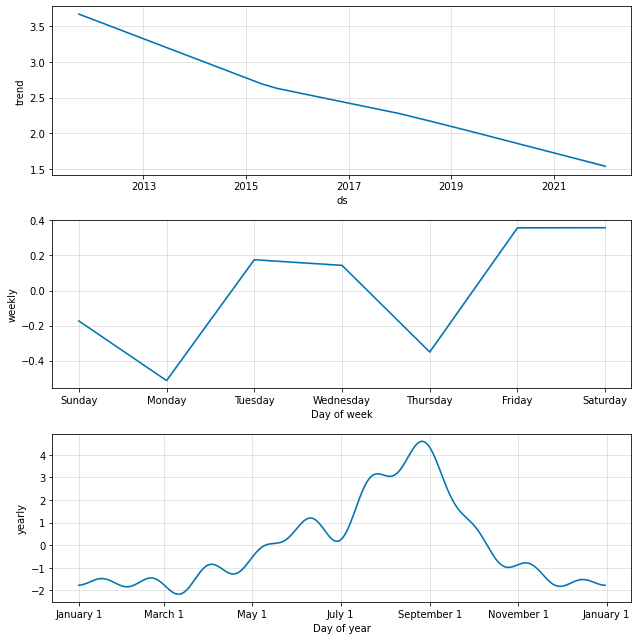

In [234]:
model_n2021.plot_components(forecast_n2021)
print('องค์ประกอบของปริมาณฝนสะสมลุ่มแม่น้ำยมตอนบนจากการทำนายปี ค.ศ. 2011-2021')
plt.show()
plt.close()

10 Year later

In [235]:
forecast_n10y, model_n10y = forecast_model(north_df, 3650, 'D')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ปริมาณฝนสะสมลุ่มแม่น้ำยมตอนบนจากการทำนายปี ค.ศ. 2011-2030


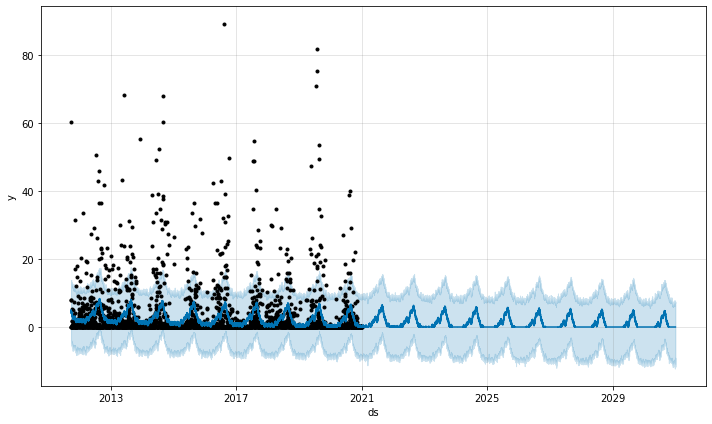

In [236]:
model_n10y.plot(forecast_n10y)
print('ปริมาณฝนสะสมลุ่มแม่น้ำยมตอนบนจากการทำนายปี ค.ศ. 2011-2030')
plt.show()
plt.close()

In [237]:
forecast_n10y[['ds','yhat']].tail(100)

,ds,yhat
6932,2030-09-21,1.847894
6933,2030-09-22,1.239204
6934,2030-09-23,0.828038
6935,2030-09-24,1.451171
6936,2030-09-25,1.356502
...,...,...
7027,2030-12-25,0.000000
7028,2030-12-26,0.000000
7029,2030-12-27,0.000000
7030,2030-12-28,0.000000


องค์ประกอบของปริมาณฝนสะสมลุ่มแม่น้ำยมตอนบนจากการทำนายปี ค.ศ. 2011-2030


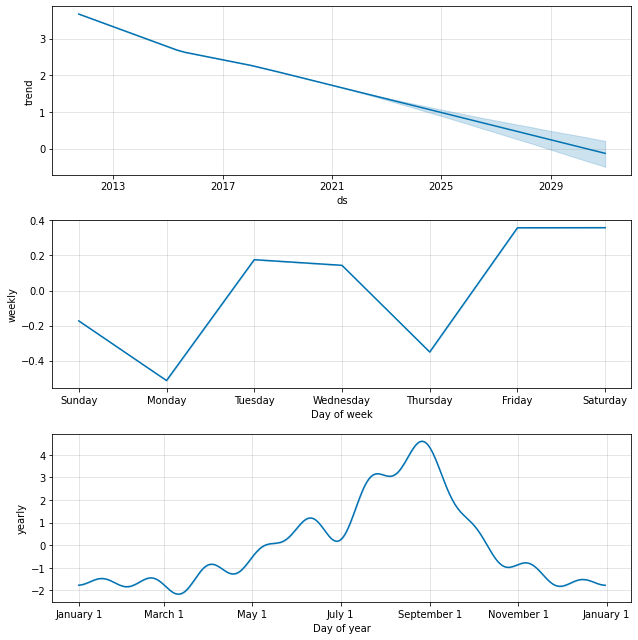

In [238]:
model_n10y.plot_components(forecast_n10y)
print('องค์ประกอบของปริมาณฝนสะสมลุ่มแม่น้ำยมตอนบนจากการทำนายปี ค.ศ. 2011-2030')
plt.show()
plt.close()

###Middle Station
สถานี อบต.วังชิ้น

1 Year later

In [239]:
forecast_m2021, model_m2021 = forecast_model(mid_df, 365, 'D')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ปริมาณฝนสะสมลุ่มแม่น้ำยมตอนกลางจากการทำนายปี ค.ศ. 2011-2021


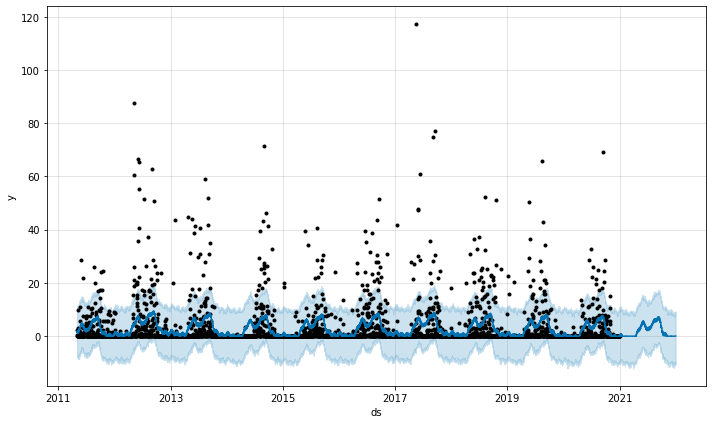

In [240]:
model_m2021.plot(forecast_m2021)
print('ปริมาณฝนสะสมลุ่มแม่น้ำยมตอนกลางจากการทำนายปี ค.ศ. 2011-2021')
plt.show()
plt.close()

องค์ประกอบของปริมาณฝนสะสมลุ่มแม่น้ำยมตอนกลางจากการทำนายปี ค.ศ. 2011-2021


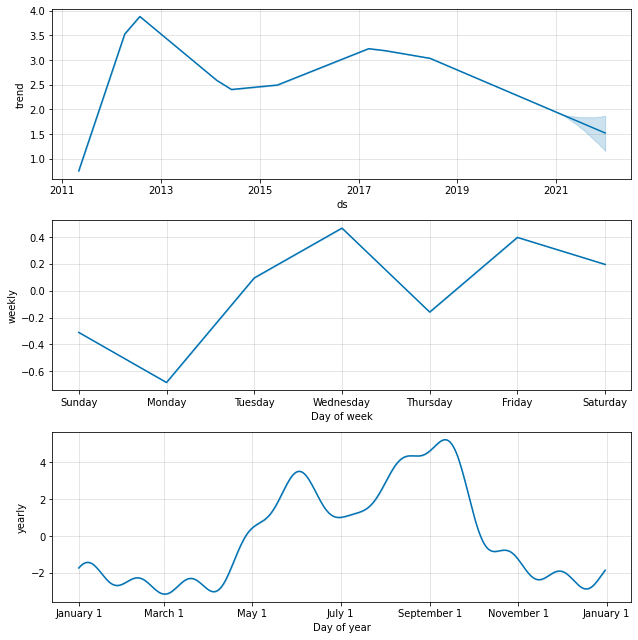

In [241]:
model_m2021.plot_components(forecast_m2021)
print('องค์ประกอบของปริมาณฝนสะสมลุ่มแม่น้ำยมตอนกลางจากการทำนายปี ค.ศ. 2011-2021')
plt.show()
plt.close()

10 Year later

In [242]:
forecast_m10y, model_m10y = forecast_model(mid_df, 3650, 'D')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ปริมาณฝนสะสมลุ่มแม่น้ำยมตอนกลางจากการทำนายปี ค.ศ. 2011-2030


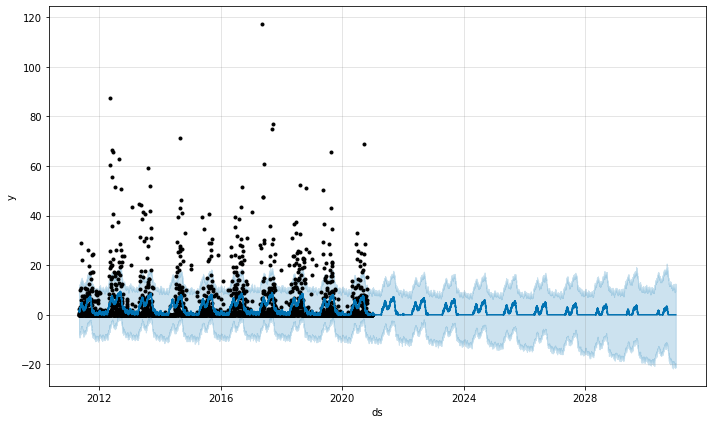

In [243]:
model_m10y.plot(forecast_m10y)
print('ปริมาณฝนสะสมลุ่มแม่น้ำยมตอนกลางจากการทำนายปี ค.ศ. 2011-2030')
plt.show()
plt.close()

In [244]:
forecast_m10y[['ds','yhat']].tail(100)

,ds,yhat
7081,2030-09-21,2.158989
7082,2030-09-22,1.407417
7083,2030-09-23,0.770127
7084,2030-09-24,1.269500
7085,2030-09-25,1.347385
...,...,...
7176,2030-12-25,0.000000
7177,2030-12-26,0.000000
7178,2030-12-27,0.000000
7179,2030-12-28,0.000000


องค์ประกอบของปริมาณฝนสะสมลุ่มแม่น้ำยมตอนกลางจากการทำนายปี ค.ศ. 2011-2030


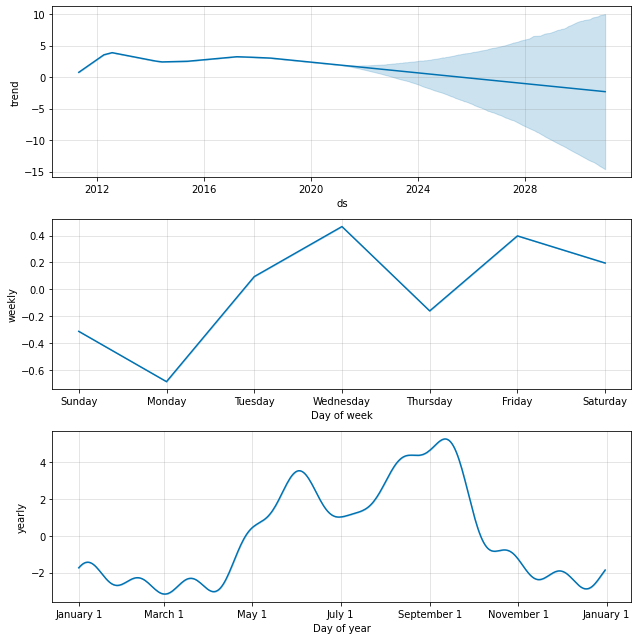

In [245]:
model_m10y.plot_components(forecast_m10y)
print('องค์ประกอบของปริมาณฝนสะสมลุ่มแม่น้ำยมตอนกลางจากการทำนายปี ค.ศ. 2011-2030')
plt.show()
plt.close()

###South Station
สถานี โรงฆ่าสัตว์ ทม.สวรรคโลก

1 Year later

In [246]:
forecast_s2021, model_s2021 = forecast_model(south_df, 365, 'D')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ปริมาณฝนสะสมลุ่มแม่น้ำยมตอนใต้จากการทำนายปี ค.ศ. 2011-2021


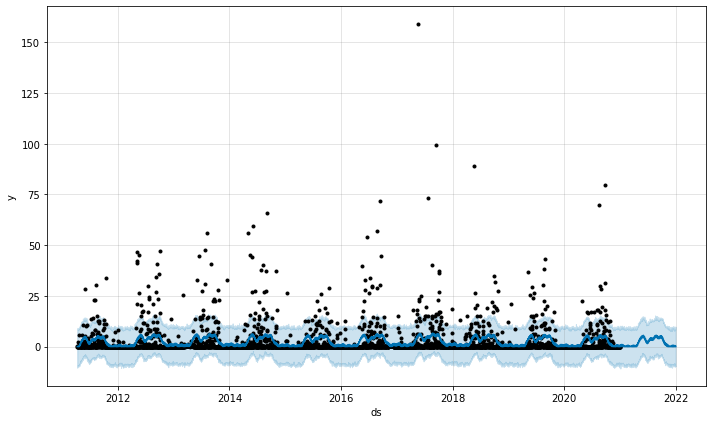

In [247]:
model_s2021.plot(forecast_s2021)
print('ปริมาณฝนสะสมลุ่มแม่น้ำยมตอนใต้จากการทำนายปี ค.ศ. 2011-2021')
plt.show()
plt.close()

องค์ประกอบของปริมาณฝนสะสมลุ่มแม่น้ำยมตอนใต้จากการทำนายปี ค.ศ. 2011-2021


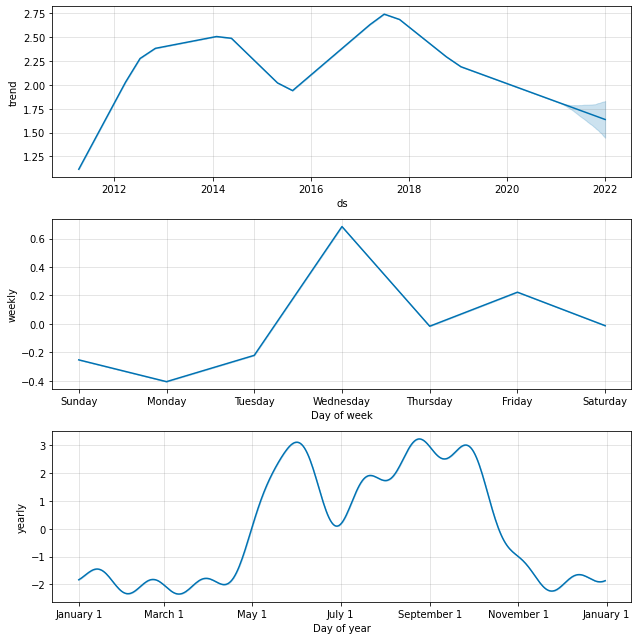

In [248]:
model_s2021.plot_components(forecast_s2021)
print('องค์ประกอบของปริมาณฝนสะสมลุ่มแม่น้ำยมตอนใต้จากการทำนายปี ค.ศ. 2011-2021')
plt.show()
plt.close()

10 Year later

In [249]:
forecast_s10y, model_s10y = forecast_model(south_df, 3650, 'D')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ปริมาณฝนสะสมลุ่มแม่น้ำยมตอนใต้จากการทำนายปี ค.ศ. 2011-2030


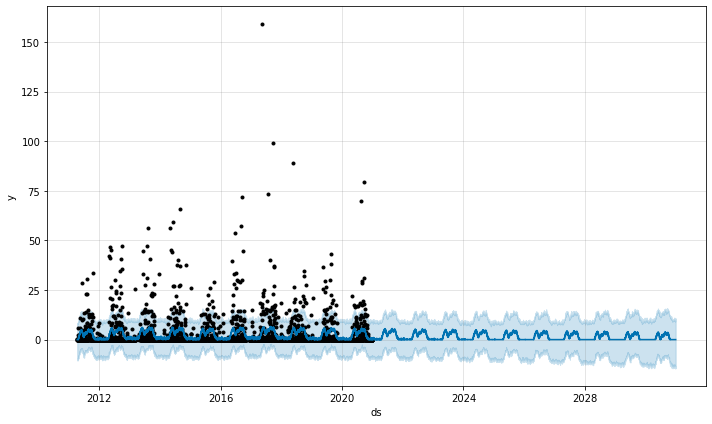

In [250]:
model_s10y.plot(forecast_s10y)
print('ปริมาณฝนสะสมลุ่มแม่น้ำยมตอนใต้จากการทำนายปี ค.ศ. 2011-2030')
plt.show()
plt.close()

In [251]:
forecast_s10y[['ds','yhat']].tail(100)

,ds,yhat
7103,2030-09-21,2.859794
7104,2030-09-22,2.663779
7105,2030-09-23,2.547555
7106,2030-09-24,2.759950
7107,2030-09-25,3.681129
...,...,...
7198,2030-12-25,0.000000
7199,2030-12-26,0.000000
7200,2030-12-27,0.000000
7201,2030-12-28,0.000000


องค์ประกอบของปริมาณฝนสะสมลุ่มแม่น้ำยมตอนใต้จากการทำนายปี ค.ศ. 2011-2030


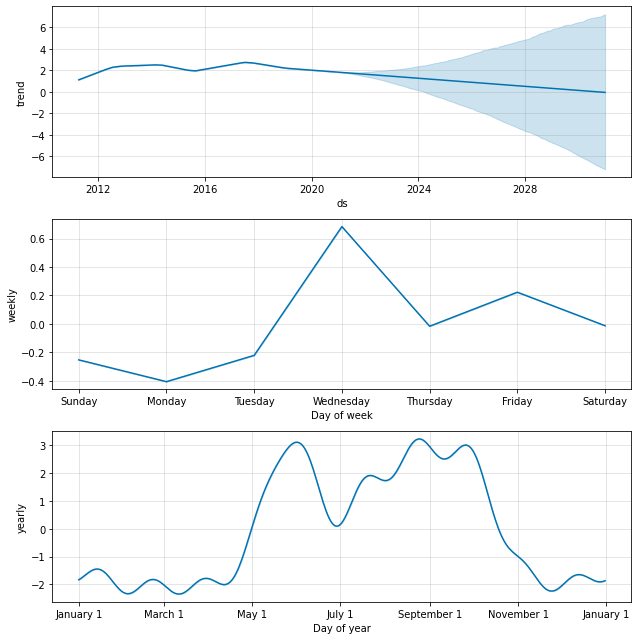

In [252]:
model_s10y.plot_components(forecast_s10y)
print('องค์ประกอบของปริมาณฝนสะสมลุ่มแม่น้ำยมตอนใต้จากการทำนายปี ค.ศ. 2011-2030')
plt.show()
plt.close()

#Data Pipeline

In [253]:
#!pip install fbprophet

In [254]:
## importing library
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.metrics import mean_squared_error
# from statsmodels.tools.eval_measures import rmse
# from fbprophet import Prophet
# import seaborn as sns
# import warnings
# warnings.filterwarnings("ignore")


******All of the functions in this cell below. You should RUN this cell before

In [255]:
def insertkey(df):
  # insert column key in df for merge data
  n_10 = df[df.date.str.contains('2010')]
  n_10.insert(0, "Key", "10")
  n_11 = df[df.date.str.contains('2011')]
  n_11.insert(0, "Key", "11")
  n_12 = df[df.date.str.contains('2012')]
  n_12.insert(0, "Key", "12")
  n_13 = df[df.date.str.contains('2013')]
  n_13.insert(0, "Key", "13")
  n_14 = df[df.date.str.contains('2014')]
  n_14.insert(0, "Key", "14")
  n_15 = df[df.date.str.contains('2015')]
  n_15.insert(0, "Key", "15")
  n_16 = df[df.date.str.contains('2016')]
  n_16.insert(0, "Key", "16")
  n_17 = df[df.date.str.contains('2017')]
  n_17.insert(0, "Key", "17")
  n_18 = df[df.date.str.contains('2018')]
  n_18.insert(0, "Key", "18")
  n_19 = df[df.date.str.contains('2019')]
  n_19.insert(0, "Key", "19")
  n_20 = df[df.date.str.contains('2020')]
  n_20.insert(0, "Key", "20")
  df = pd.concat([n_10, n_11, n_12, n_13, n_14, n_15, n_16, n_17, n_18, n_19, n_20], sort=False)
  return df

def insertkey_forest(df):
  # insert column key in nf_df for merge data
  nf_10 = df[df['Year'] == '2010']
  nf_10.insert(0, "Key", "10")
  nf_11 = df[df['Year'] == '2011']
  nf_11.insert(0, "Key", "11")
  nf_12 = df[df['Year'] == '2012']
  nf_12.insert(0, "Key", "12")
  nf_13 = df[df['Year'] == '2013']
  nf_13.insert(0, "Key", "13")
  nf_14 = df[df['Year'] == '2014']
  nf_14.insert(0, "Key", "14")
  nf_15 = df[df['Year'] == '2015']
  nf_15.insert(0, "Key", "15")
  nf_16 = df[df['Year'] == '2016']
  nf_16.insert(0, "Key", "16")
  nf_17 = df[df['Year'] == '2017']
  nf_17.insert(0, "Key", "17")
  nf_18 = df[df['Year'] == '2018']
  nf_18.insert(0, "Key", "18")
  nf_19 = df[df['Year'] == '2019']
  nf_19.insert(0, "Key", "19")
  nf_20 = df[df['Year'] == '2020']
  nf_20.insert(0, "Key", "20")
  df = pd.concat([nf_10, nf_11, nf_12, nf_13, nf_14, nf_15, nf_16, nf_17, nf_18, nf_19, nf_20], sort=False)
  return df

def prepare_forestdata(forest_df, Province):
  nf_df = forest_df[forest_df['Province'] == Province]
  nf_df = nf_df.astype(str)
  nf_df = insertkey_forest(nf_df)
  return nf_df
  
def combine_with_forest(df, f_df):
  data = pd.merge(df, f_df, on="Key", how="outer")
  return data


def drop_range_unavailable(df):
  idx = df['rain1h'].ne(-999).idxmax()
  df = df.drop(range(0, idx))
  return df


def drop_column(df, column):
  df = df.drop(columns = column, axis = 1)
  return df


def replacwithnan(df):
  df = df.replace({-999: np.nan})
  return df

  
def fill_missing_value(df):
  feature_missing = df.columns[df.isnull().any()].tolist()
  df_original = df.copy()
  for i in feature_missing:
    np.random.seed(0)
    nan_rows = df[i].isna()
    random_feat = np.random.choice(df[i][~nan_rows], replace=True, size=sum(nan_rows)) 
    df.loc[nan_rows,i] = random_feat
  return df

def transformtoOneday(df):
  df_new = df.groupby('date')['temp_out','press','humid'].mean()
  df_new['rain1d'] = df.groupby('date')['rain1h'].sum()
  df_temp = df.groupby('date')['Key','code','Province_Area','Forest_Area','Percent_of_Province_Area','Non_Forest_Area'].first()
  dff = pd.concat([df_temp, df_new], axis=1)
  dff['Date'] = df['date'].unique()
  first_column = dff.pop('Date')
  dff.insert(0, 'Date', first_column)
  dff.reset_index(drop=True, inplace=True)
  return dff

def transform_index(dataframe):
  df = dataframe.copy()
  df = df.set_index('Date')
  return df

def forecast_model(df, period, freq):
  #Preprocessing
  df_new = df[['Date', 'rain1d']]
  df_new = df_new.rename(columns={'Date':'ds', 'rain1d':'y'})
  #Modeling
  m = Prophet()
  m.fit(df_new)
  future = m.make_future_dataframe(periods=period, freq= freq)
  prophet_pred = m.predict(future)
  prophet_pred.loc[(prophet_pred['yhat'] < 0.0),'yhat']= 0.0
  return prophet_pred, m

##Select your station

In [256]:
#Optional to find the code of the station
# download description file
!gdown --id 1GJdM5L1SH1Cs95xFeflf3HT7kLT4wd-f
description = pd.read_csv('st.csv')

#Replace 'ทต.เชียงม่วน' with the name of the station
description[description['name'] == 'ทต.เชียงม่วน']

Downloading...
From: https://drive.google.com/uc?id=1GJdM5L1SH1Cs95xFeflf3HT7kLT4wd-f
To: /content/st.csv
100% 20.8k/20.8k [00:00<00:00, 14.5MB/s]


,code,name,lat,long,tambon,amphoe,province,basin,region,station_type
32,CGMN,ทต.เชียงม่วน,18.893837,100.28784,เชียงม่วน,เชียงม่วน,พะเยา,ภาคเหนือ,R,NaN


Find id link of the station data in the following steps <br>


1.   Go to [Storage file](https://drive.google.com/drive/folders/1ezFS9OX_Mmj8V-rSclCaBi8Mqthv2hA-?usp=sharing)
2.   Click to data directory
3.   Suppose the code is 'CGMN' scroll up/down to find the file which has a name same as the code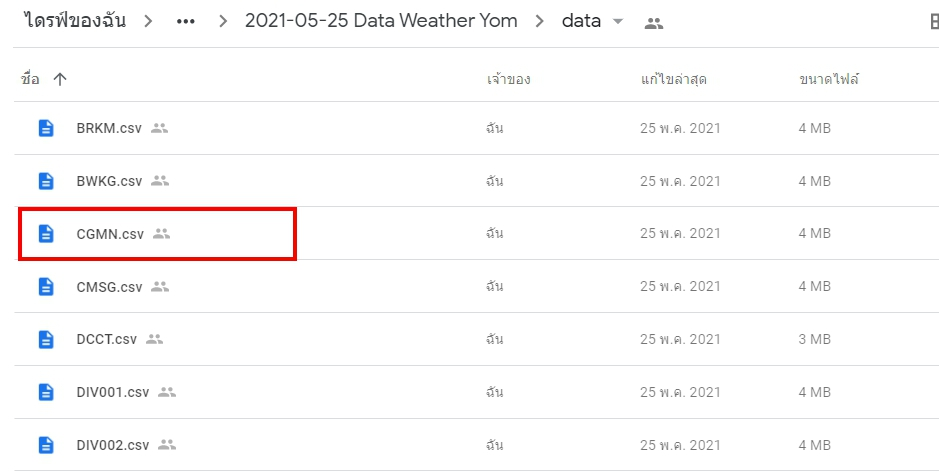
4. Open file > 3 dot at the top right > share > copy id as seen in the picture 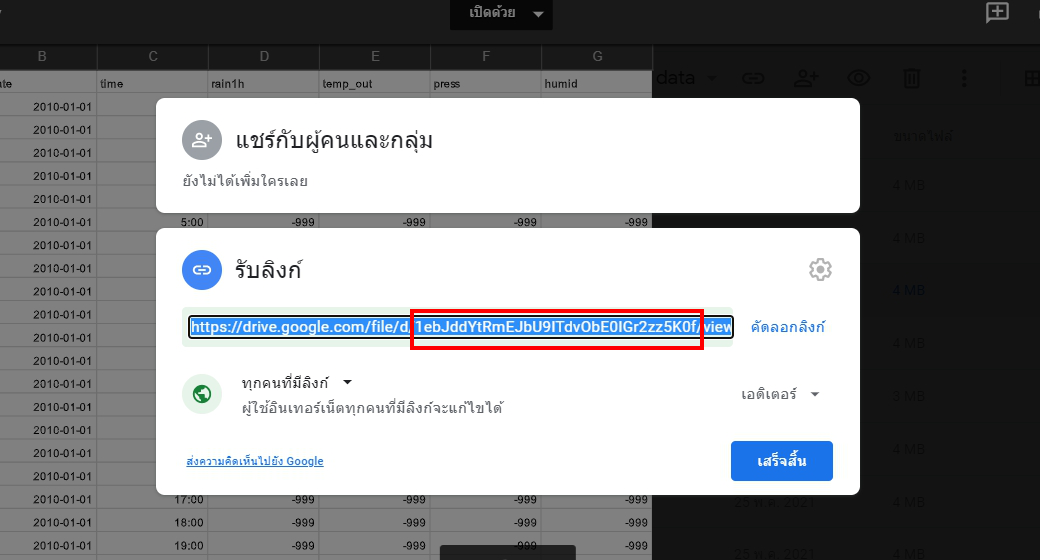


In [257]:
# paste the id aftter --id
!gdown --id 1ebJddYtRmEJbU9ITdvObE0IGr2zz5K0f

# paste 'CGMN.csv' with the code of station and .csv
df = pd.read_csv('CGMN.csv')

# download forest file
!gdown --id 1pv_GeEmjiED-x_3KFTkIzKaYAIhTr_QG
forest_df = pd.read_csv('ForestNorth_2013-2019.csv')

Downloading...
From: https://drive.google.com/uc?id=1ebJddYtRmEJbU9ITdvObE0IGr2zz5K0f
To: /content/CGMN.csv
3.72MB [00:00, 118MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pv_GeEmjiED-x_3KFTkIzKaYAIhTr_QG
To: /content/ForestNorth_2013-2019.csv
100% 1.55k/1.55k [00:00<00:00, 1.13MB/s]


##Automation

In [258]:
def forecasting_pipeline(df, forest_df, province, period, freq):

  #Combining data
  df = insertkey(df)
  f_df = prepare_forestdata(forest_df, Province = province)
  df = combine_with_forest(df, f_df)

  #Cleansing data
  df = drop_column(df, ['Province','Year'])
  df = drop_range_unavailable(df)
  df = replacwithnan(df)
  df = fill_missing_value(df)

  #Transform data
  df = transformtoOneday(df)

  #Modeling
  forecast, model = forecast_model(df, period, freq)

  #Visualization
  model.plot(forecast)
  print('ปริมาณฝนสะสมลุ่มแม่น้ำยมจากการทำนาย')
  plt.show()
  plt.close()

  model.plot_components(forecast)
  print('องค์ประกอบของข้อมูลปริมาณฝนสะสมลุ่มแม่น้ำยมจากการทำนาย')
  plt.show()
  plt.close()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ปริมาณฝนสะสมลุ่มแม่น้ำยมจากการทำนาย


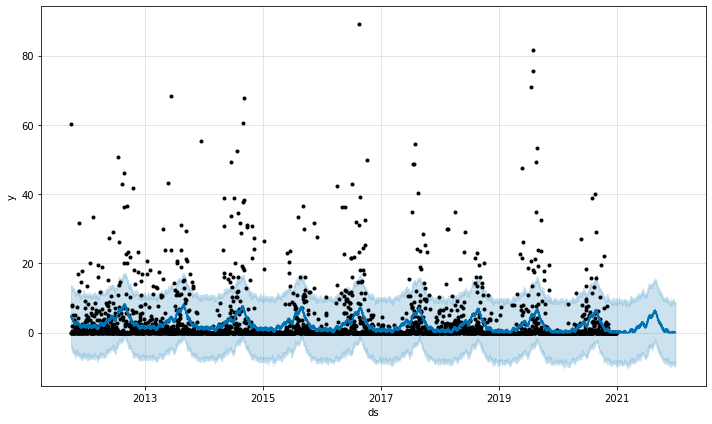

องค์ประกอบของข้อมูลปริมาณฝนสะสมลุ่มแม่น้ำยมจากการทำนาย


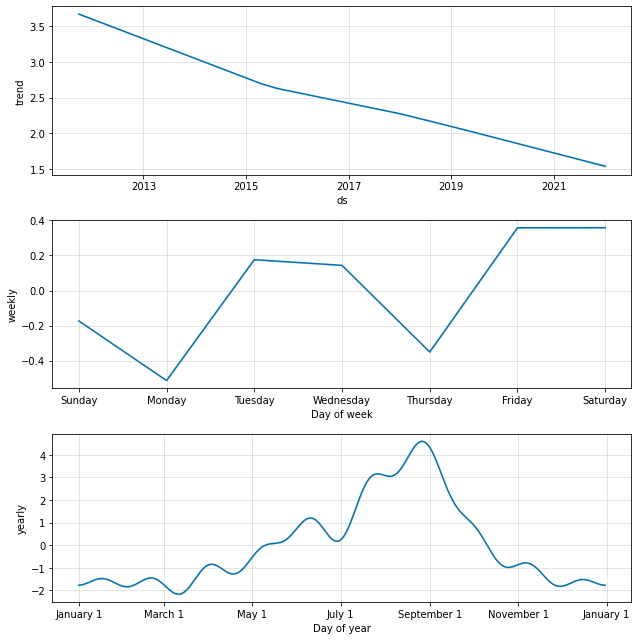

In [259]:
forecast_demo = forecasting_pipeline(df, forest_df, province='ตอนบน', period=365, freq='D')